## Importowanie bibliotek

In [1]:
import numpy as np
import pandas as pd
import math

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import shapiro, spearmanr, chi2
from scipy.stats import t as tstud

import statsmodels.api as sm

%matplotlib inline

# Ustawiamy poziom istotności. We wszystkich zadaniach zdecydowałem używać alpha = 0.01
alpha = 0.01
num_cols = 2
target_variable = 'wydatki_zyw'

## Wczytanie zbioru do ramki danych
Na początku wczytujemy dane z pliku do DataFrame, gdzie jako kolumnę indeksową przyjmujemy id, ponieważ nie zawiera ona żadnej dodatkowej informacji.

In [2]:
df = pd.read_csv('dane_projekt1.csv', delimiter=';', index_col='id')

# Zadanie 1

## 1.1)

Zobaczmy jaką strukturę mają nasze dane, poprzez wypisanie pierwszych kilku obserwacji.

In [3]:
df.head()

waga  wzrost  plec  dzieci  wiek   dochod  oszczednosci  jednoos  \
id                                                                       
52   78.93  176.20     2       5    59   979.01        673.17        0   
101  78.66  165.73     1       3    52  1043.36        543.89        0   
146  74.29  171.33     1       2    57  1227.69        773.20        0   
281  79.11  169.24     1       1    59  2356.74       1914.74        1   
167  79.23  177.78     2       1    48  1264.95        536.29        1   

     miejsce  wydatki_zyw  
id                         
52         3       194.96  
101        2       259.20  
146        1       244.41  
281        2       239.77  
167        3       291.05

Sprawdzimy, jakiego typu są poszczególne kolumny.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 310 entries, 52 to 171
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   waga          310 non-null    float64
 1   wzrost        310 non-null    float64
 2   plec          310 non-null    int64  
 3   dzieci        310 non-null    int64  
 4   wiek          310 non-null    int64  
 5   dochod        310 non-null    float64
 6   oszczednosci  310 non-null    float64
 7   jednoos       310 non-null    int64  
 8   miejsce       310 non-null    int64  
 9   wydatki_zyw   310 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 26.6 KB


Wszystkie kolumny są typu liczbowego. 

Waga, wzrost, dochód, oszczędności i wydatki na żywność są typu zmiennoprzecinkowego.

Płeć, liczba dzieci, wiek, status gospodarstwa domowego i miejsce zamieszkania są typu całkowitego.

Teraz sprawdzimy, jaką kardynalność mają poszczególne cechy.

In [5]:
df.nunique()

waga            270
wzrost          297
plec              2
dzieci            6
wiek             35
dochod          310
oszczednosci    310
jednoos           2
miejsce           3
wydatki_zyw     304
dtype: int64

Widzimy, że niską kardynalnością cechują się:
- płeć,
- liczba dzieci,
- status gospodarstwa domowego,
- wielkość miejscowości zamieszkania.

Dodatkowo, średnią kardynalnością (35 unikalnych wartości) cechuje się wiek respondentów.

Pozostałe zmienne cechują się wyższą kardynalnością.

Sprawdzamy, czy w zbiorze występują braki w danych.

In [6]:
df.isnull().sum()

waga            0
wzrost          0
plec            0
dzieci          0
wiek            0
dochod          0
oszczednosci    0
jednoos         0
miejsce         0
wydatki_zyw     0
dtype: int64

W analizowanym zbiorze mamy 310 obserwacji. 
Nie występują braki w danych.

Jest 8 zmiennych ilościowych, są to:
- id (kolumna indeksowa),
- waga,
- wzrost,
- liczba dzieci,
- wiek,
- dochód,
- oszczędności,
- deklarowane wydatki na żywność. 

Pozostałe 3 zmienne są jakościowe:
- płeć,
- status gospodarstwa domowego,
- wielkość miejscowości.


In [7]:
NUM_FEATURES = ['waga', 'wzrost', 'dzieci', 'wiek', 'dochod', 'oszczednosci', 'wydatki_zyw']
CAT_FEATURES = ['plec', 'jednoos', 'miejsce']

## 1.2)
### Statysytki opisowe dla zmiennych ilościowych

In [8]:
df[NUM_FEATURES].describe()

waga      wzrost      dzieci        wiek        dochod  \
count  310.000000  310.000000  310.000000  310.000000    310.000000   
mean    79.814742  172.726774    2.003226   56.241935   1519.658000   
std      3.292902    6.906733    1.352209    6.746653   1293.464325   
min     68.890000  155.670000    0.000000   37.000000    645.270000   
25%     77.430000  167.090000    1.000000   52.000000    966.807500   
50%     79.890000  172.815000    2.000000   56.000000   1190.840000   
75%     82.112500  178.032500    3.000000   61.000000   1620.460000   
max     86.730000  190.790000    5.000000   77.000000  17412.240000   

       oszczednosci   wydatki_zyw  
count    310.000000    310.000000  
mean     945.994839     12.383097  
std      787.601212   3232.382607  
min     -204.240000 -55640.190000  
25%      392.545000    199.757500  
50%      741.190000    249.265000  
75%     1270.222500    283.267500  
max     5485.220000    301.690000

Zauważmy, że w naszym zbiorze występują obserwację z ujemnymi wydatkami na żywność. W dokumentacji nie ma wzmianki o interpretacji ujemnych wartości wydatków na żywność (nie tak jak w przypadku oszczędności), więc zdecydowałem się usunąć je z naszego zbioru.

In [9]:
df[df['wydatki_zyw'] < 0]

waga  wzrost  plec  dzieci  wiek    dochod  oszczednosci  jednoos  \
id                                                                        
308  77.76  171.11     1       2    56   5955.49       3521.98        1   
306  84.66  168.19     2       1    53   5103.53       3350.77        1   
310  77.87  170.23     1       5    55  17412.24       5485.22        1   
307  77.16  163.86     1       1    48   5784.33       3774.89        1   
305  78.44  165.26     1       5    57   4929.33       3336.75        1   
309  81.61  173.70     1       2    63   9557.08       3844.10        1   

     miejsce  wydatki_zyw  
id                         
308        3      -939.57  
306        2      -133.78  
310        1    -55640.19  
307        2      -391.43  
305        2        -1.06  
309        3    -10668.84

Widzimy, że takich obserwacji jest 6. Usuwamy je z naszej ramki z danymi.

In [10]:
df = df[df['wydatki_zyw'] >= 0]

Po usunięciu obserwacji ponownie policzmy statystyki opisowe.

In [11]:
df[NUM_FEATURES].describe()

waga      wzrost      dzieci        wiek       dochod  \
count  304.000000  304.000000  304.000000  304.000000   304.000000   
mean    79.819309  172.805757    1.990132   56.259868  1389.315724   
std      3.303614    6.935242    1.341112    6.782444   660.781113   
min     68.890000  155.670000    0.000000   37.000000   645.270000   
25%     77.415000  167.130000    1.000000   51.750000   965.830000   
50%     79.895000  172.890000    2.000000   56.500000  1181.350000   
75%     82.142500  178.117500    3.000000   61.000000  1613.947500   
max     86.730000  190.790000    5.000000   77.000000  4780.150000   

       oszczednosci  wydatki_zyw  
count    304.000000   304.000000  
mean     887.975954   235.571151  
std      668.759849    57.232769  
min     -204.240000    56.270000  
25%      384.657500   204.207500  
50%      722.325000   250.465000  
75%     1236.880000   284.110000  
max     3390.590000   301.690000

Po usunięciu obserwacji z ujemnymi wydatkami na żywność zostają nam 304 obserwacje.

Skomentujmy standardowe statystyki opisowe:
- Waga cechuje się niskim odchyleniem standardowym (3.3 kg), średnia wynosi 79.8 kg. Minimalna waga w zbiorze jest równa 68.89 kg, natomiast maksymalna 86.73 kg.
- Wzrost cechuje się niskim odchyleniem standardowym (6.9 cm), średnia wynosi 172.8 cm. Minimalny wzrost jest równy 155.67 cm, natomiast maksymalny 190.79 cm.
- Liczba dzieci cechuje się niskim odchyleniem standardowym (1.34), średnia w przybliżeniu wynosi 2. Minimalna liczba dzieci jest równa 0, natomiast maksymalna 5.
- Wiek cechuje się niskim odchyleniem standardowym (6.78 lat), średnia wynosi 56.3 lat. Minimalny wiek jest równy 37, natomiast maksymalny 77 lat.
- Dochód cechuje się wysokim odchyleniem standardowym (660.8 bajtalarów), średnia wynosi 1389.3. Minimalny dochód jest równy 645.27, natomiast maksmylany 4780.15 bajtalarów.
- Oszczędności cechują się wysokim odchyleniem standardowym (668.76 bajtalarów), średnia wynosi 888. Minimalne oszczędności są równe -204.24, natomiast maksymalne 3390.59 bajtalarów.
- Wydatki na żywność cechują się średnim odchyleniem standardowym (57.23 bajtalarów), średnia wynosi 235.6. Minimalne wydatki są równe 56.25, natomiast maksymalne 301.69 bajtalarów. 

Podsumujmy i zaznaczmy istotne fakty:
- W zbiorze danych występuję ujemne wartości oszczędności. 
- Maksymalna liczba dzieci wynosi 5.
- Maksymalny wiek wynoszący 77 lat może oznaczać obecność osób starszych.
- Dużym odchyleniem standardowym cechują się oszczędności i dochód, natomiast małym liczba dzieci czy waga. 
- Minimalne wydatki na żywność leżą dużo poniżej 1-wszego kwartyla.

### Tabele częstości dla zmiennych jakościowych


In [12]:
for cat_feature in CAT_FEATURES:
    print(f"{df[cat_feature].value_counts()}\n")

plec
1    163
2    141
Name: count, dtype: int64

jednoos
0    177
1    127
Name: count, dtype: int64

miejsce
2    138
3     83
1     83
Name: count, dtype: int64



Skomentujmy tabele częstości:
- W naszej próbie przeważają kobiety o 22 osoby. Kobiet jest 163, natomiast mężczyzn 141.
- W gospodarstwach wieloosobowych mieszka o 50 osób więcej niż gospodarstwach jednoosobowych, w których mieszka 127 respondentów.
- Najwięcej z nich pochodzi z miejscowości o średniej wielkości (138), natomiast po 83 osoby pochodzą z małych oraz dużych miejscowości.

## 1.3)
### Analiza rozkładów zmiennych

Podzielimy zmienne ze względu na kardynalność, aby następnie zwizualizować je na odpowiednim typie wykresu. Jako wartość graniczną przyjąłem 40 różnych wartości.

In [13]:
LOW_CARDINALITY = []
HIGH_CARDINALITY = []

for feature in df.columns:
    if df[feature].nunique() <= 40:
        LOW_CARDINALITY.append(feature)
    else:
        HIGH_CARDINALITY.append(feature)

print(f"{LOW_CARDINALITY}")
print(f"{HIGH_CARDINALITY}")


['plec', 'dzieci', 'wiek', 'jednoos', 'miejsce']
['waga', 'wzrost', 'dochod', 'oszczednosci', 'wydatki_zyw']


### Wykresy słupkowy dla zmiennych z małą kardynalnością
Zmienne z małą kardynalnością zwizualizujemy za pomocą wykresów słupkowych częstości.

In [14]:
def plot_bar(df_to_plot):
    num_rows = 3
    fig = sp.make_subplots(rows=num_rows, cols=num_cols)

    for i, feature in enumerate(LOW_CARDINALITY, start=1):
        frequency_table = df_to_plot[feature].value_counts().reset_index()
        frequency_table.columns = [feature, 'Liczba wystąpień']
    
        fig.add_trace(
            go.Bar(x=frequency_table[feature], y=frequency_table['Liczba wystąpień'], name=feature),
            row=(i-1)//num_cols+1, col=(i-1)%num_cols+1
        )
        fig.update_yaxes(title_text=f'Liczba wystąpień {feature}', row=(i-1)//num_cols+1, col=(i-1)%num_cols+1)
        fig.update_xaxes(title_text=f'{feature}', row=(i-1)//num_cols+1, col=(i-1)%num_cols+1)


    fig.update_layout(height=400*num_rows, width=1400, title_text="Rozkłady zmiennych o niższej kardynalności (wykresy słupkowe)")
    fig.show()
    
plot_bar(df)

Poczyńmy następujące obserwacje:
- wiek wizualnie przypomina rozkład normalny,
- najwięcej respondentów jest w wieku 24 lat,
- najwięcej respondentów ma 1 dziecko i od tego momentu obserwujemy spadek liczby osób wraz ze wzrostem liczby dzieci,
- 87.5% osób ma co najmniej jedno dziecko,
- pozostałe zmienne są jakościowe i ich rozkład skomentowaliśmy przy tabelach częstości.

### Histogramy dla zmiennych ilościowych o większej kardynalności

In [15]:
def plot_histograms(df_to_plot, fixed_bins):
    num_rows = 3

    fig = sp.make_subplots(rows=num_rows, cols=num_cols)

    for i, feature in enumerate(HIGH_CARDINALITY, start=1):
        if not fixed_bins:
            fig.add_trace(
                go.Histogram(x=df_to_plot[feature], name=feature),
                row=(i-1)//num_cols+1, col=(i-1)%num_cols+1
            )
        else:
            fig.add_trace(
                go.Histogram(x=df_to_plot[feature], name=feature, nbinsx=df_to_plot[feature].nunique()),
                row=(i-1)//num_cols+1, col=(i-1)%num_cols+1
            ) 
            
        fig.update_yaxes(title_text=f'Liczba wystąpień {feature}', row=(i-1)//num_cols+1, col=(i-1)%num_cols+1)
        fig.update_xaxes(title_text=f'{feature}', row=(i-1)//num_cols+1, col=(i-1)%num_cols+1)

    fig.update_layout(height=400*num_rows, width=1400, title_text="Rozkłady zmiennych o wyższej kardynalności (histogramy)")
    fig.show()
    
plot_histograms(df, False)

Poczyńmy następujące obserwacje:
- waga oraz wzrost wizualnie przypominają rozkład normalny,
- dochód oraz oszczędności cechują się ciężkim ogonem z prawej strony,
- wydatki na żywność cechują się ciężkim ogonem z lewej strony,
- waga aż 70 osób mieści się w przedziale 80-82 kg,
- wydatki na żywność 89 osób są w przedziale pomiędzy 280 a 300 bajtalarów,
- dwie osoby mają miesięczny dochód, który przewyższa 4000 bajtalarów.

### Wykresy pudełkowe dla zmiennych ilościowych

In [16]:
def plot_box_plots(df_to_plot):
    num_rows = 3
    fig = sp.make_subplots(rows=num_rows, cols=num_cols)

    for i, feature in enumerate(HIGH_CARDINALITY, start=1):
        fig.add_trace(
            go.Box(y=df_to_plot[feature], name=feature),
            row=(i-1)//num_cols+1, col=(i-1)%num_cols+1
        )
        fig.update_yaxes(title_text=f'{feature}', row=(i-1)//num_cols+1, col=(i-1)%num_cols+1)

    fig.update_layout(height=400*num_rows, width=1400, title_text="Rozkłady zmiennych o wyższej kardynalności (wykresy pudełkowe)")
    fig.show()
    
plot_box_plots(df)

Na wykresach pudełkowych możemy zauważyć obserwacje odstające:
- w dochodzie oraz oszczędnościach występują outlierzy odstający w górę,
- w wydatkach na żywność występują outlierzy odstający w dół,
- największą liczbą obserwacji odstających cechuje się dochód.

### Wykresy kwantyl-kwantyl dla zmiennych ilościowych

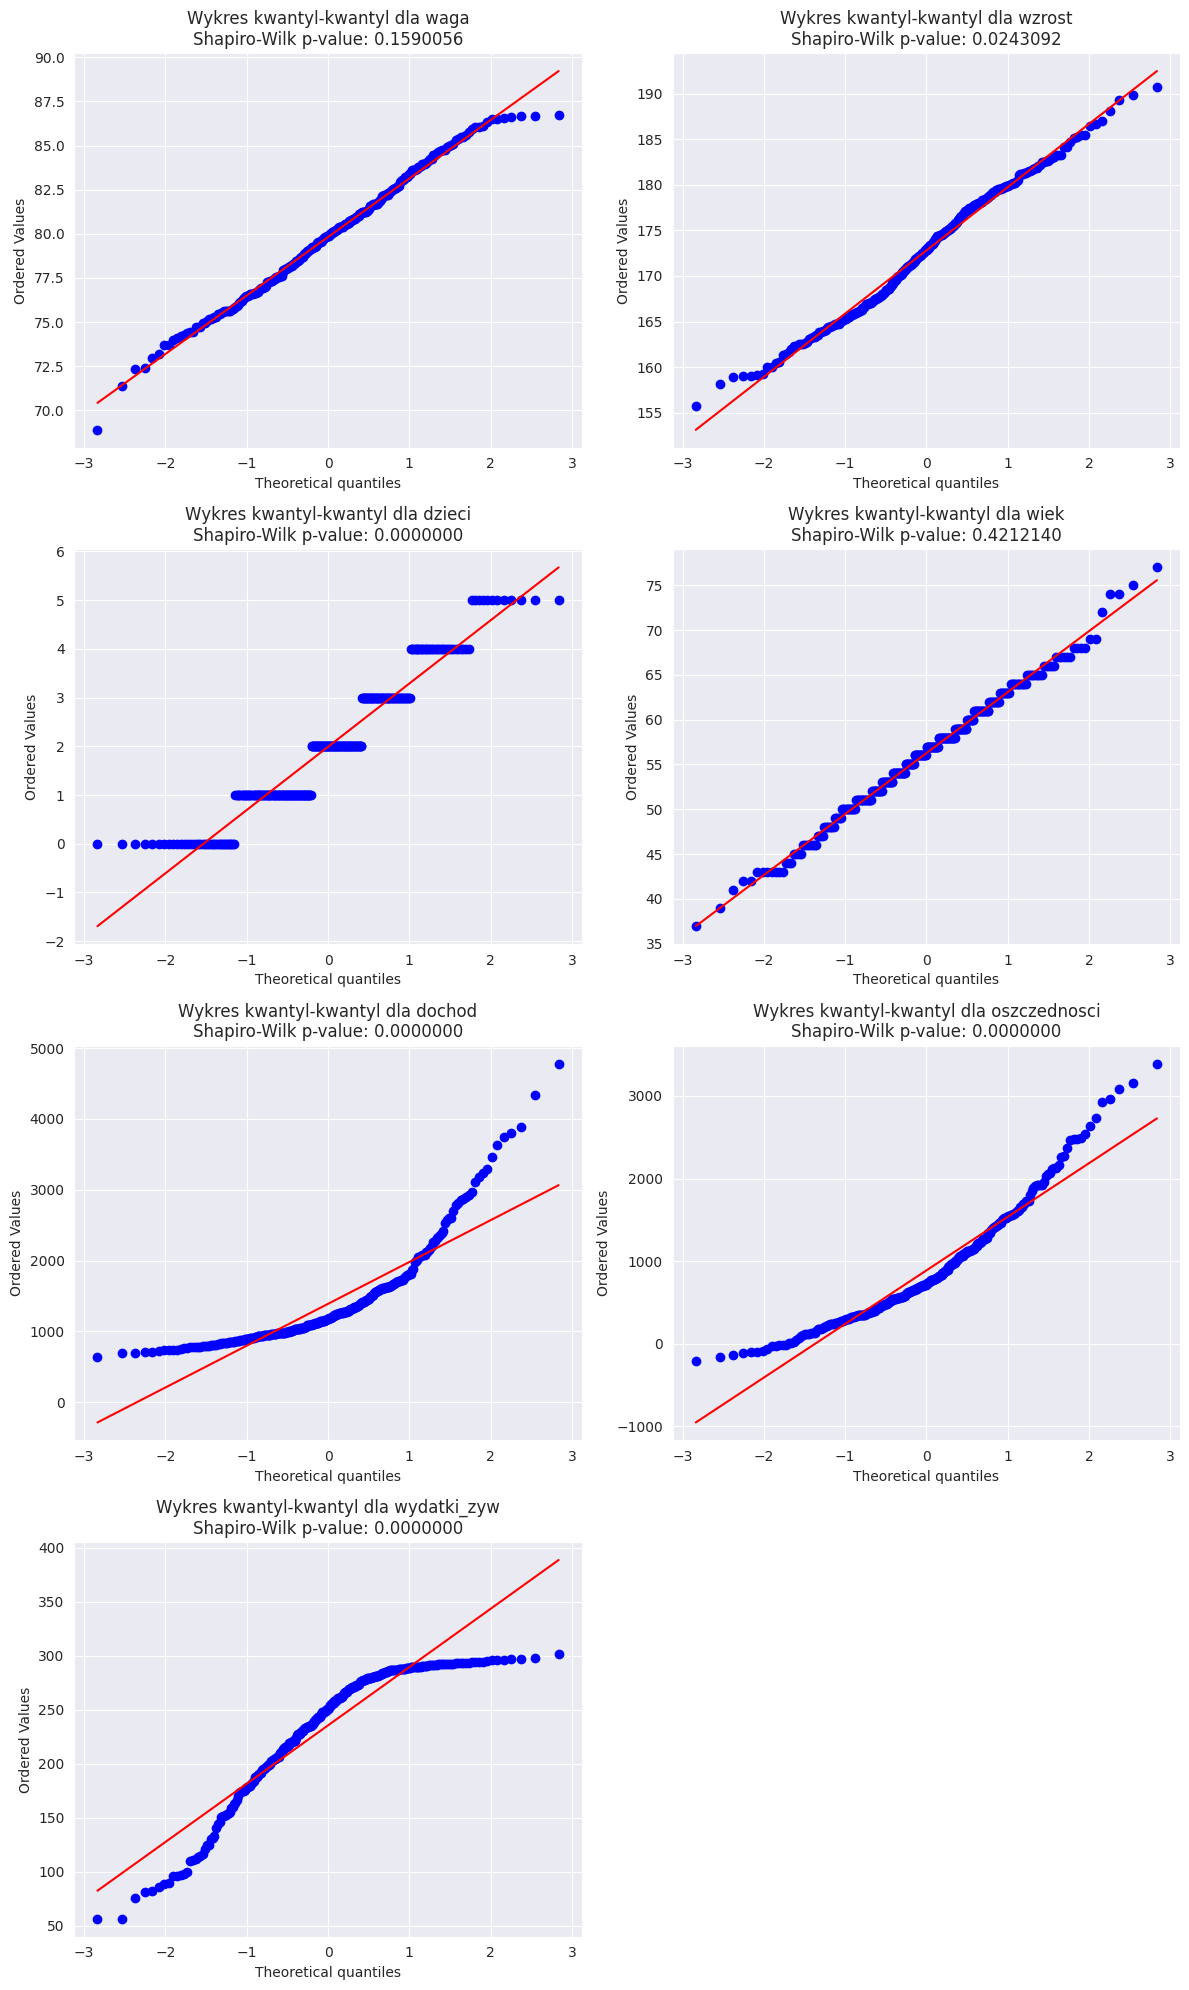

In [17]:
num_rows = 4
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, num_rows*5))

for ax, num_feature in zip(axs.flatten(), NUM_FEATURES):
    stat, p = shapiro(df[num_feature])

    stats.probplot(df[num_feature], dist='norm', plot=ax)
    ax.set_title(f'Wykres kwantyl-kwantyl dla {num_feature}\nShapiro-Wilk p-value: {p:.7f}')
    ax.grid(True)

if len(NUM_FEATURES) < num_rows * num_cols:
    for ax in axs.flatten()[len(NUM_FEATURES):]:
        fig.delaxes(ax)

plt.tight_layout()
plt.show()

### Test Shapiro-Wilka dla zmiennych ilościowych

Stawiamy hipotezę zerową i alternatywną:

$$ H_0: \; \text{Zmienna pochodzi z populacji o rozkładzie normalnym.} $$
$$ H_1: \; \text{Zmienna nie pochodzi z populacji o rozkładzie normalnym.} $$

Ustalamy poziom istotności $\alpha = 0.01$ i obliczmy $p$-wartość.

In [18]:
reject_normality = []
no_rejection = []

for num_feature in NUM_FEATURES:
    stat, p_value = shapiro(df[num_feature])
    if p_value > alpha:
        no_rejection.append(num_feature)
    else:
        reject_normality.append(num_feature)
    
    print(f"Test shapiro dla {num_feature}")
    print(f"Wartość statystyki testowej: {stat}")
    print(f"P-wartość: {p_value}\n")
    
print(f"Dla następujących zmiennych odrzucamy hipotezę zerową o normalności:\n{reject_normality}")    
print(f"\nDla następujących zmiennych nie mamy podstaw do odrzucenia hipotezy zerowej:\n{no_rejection}")

Test shapiro dla waga
Wartość statystyki testowej: 0.9929033696225562
P-wartość: 0.15900560659128582

Test shapiro dla wzrost
Wartość statystyki testowej: 0.9892594665139154
P-wartość: 0.02430922364511628

Test shapiro dla dzieci
Wartość statystyki testowej: 0.9213227340767145
P-wartość: 1.4731241487643676e-11

Test shapiro dla wiek
Wartość statystyki testowej: 0.9949513221517189
P-wartość: 0.42121402853271034

Test shapiro dla dochod
Wartość statystyki testowej: 0.7908118576114409
P-wartość: 1.8410858979431478e-19

Test shapiro dla oszczednosci
Wartość statystyki testowej: 0.9290091905774026
P-wartość: 7.38350025459219e-11

Test shapiro dla wydatki_zyw
Wartość statystyki testowej: 0.8780767319751849
P-wartość: 8.072505039796154e-15

Dla następujących zmiennych odrzucamy hipotezę zerową o normalności:
['dzieci', 'dochod', 'oszczednosci', 'wydatki_zyw']

Dla następujących zmiennych nie mamy podstaw do odrzucenia hipotezy zerowej:
['waga', 'wzrost', 'wiek']


Nasze zmienne możemy podzielić na:

1. Dane wizualnie przypominające rozkład normalny. 
- Są to: waga, wzrost, wiek. Cechują się one symetrycznym rozkładem, mediana jest zbliżona do średniej.

2. Dane przypominające rozkład przesunięty w prawo. 
- Są to: oszczędności, dochód. Cechują się ciężkim ogonem z prawej strony (małe obserwacje są zredukowane, natomiast górny ogon jest rozszerzony w stosunku do rozkładu normalnego).

3. Dane przypominające rozkład przesunięty w lewo.
- Są to: wydatki żywnościowe. Odwrotnie niż do rozkładu przesuniętego w prawo, cechują się ciężkim ogonem z prawej strony (duże obserwacje są zredukowane, natomiast dolny ogon jest rozszerzony w stosunku do rozkładu normalnego).

# Zadanie 2

## Analiza zależności pomiędzy zmiennymi ilościowymi
Aby sprawdzić, czy występują zależności pomiędzy zmiennymi ilościowymi, użyjemy współczynnika korelacji Spearmana. Współczynnik korelacji Pearsona nie jest odpowiednim wyborem, ponieważ oddaje tylko zależność liniową, a dodatkowo nie jest odporny na występowanie obserwacji odstających (które u nas występują) czy rozkład zmiennych, który nie jest normalny (odrzuciliśmy hipotezę zerową dla 4 zmiennych). 

Wybrałem współczynnik Spearmana, ponieważ korelacja rangowa mierzy, w jakim stopniu, gdy jedna zmienna rośnie, to druga też wzrasta, bez konieczności by wzrost ten był wyrażony zależnością liniową.


Stawiamy hipotezę zerową i alternatywną:

$$H_0: \; p_{ij} = p_{i.}p_{.j} \; \forall_{i, j} \quad \text{(niezależność zmiennych)}$$
$$H_1: \; p_{ij} \neq p_{i.}p_{.j}$$

Ustalamy poziom istotności $\alpha = 0.01$ i obliczmy $p$-wartość.

W nawiasach podana jest $p$-wartość, natomiast bez nich współczynnik korelacji Spearmana.


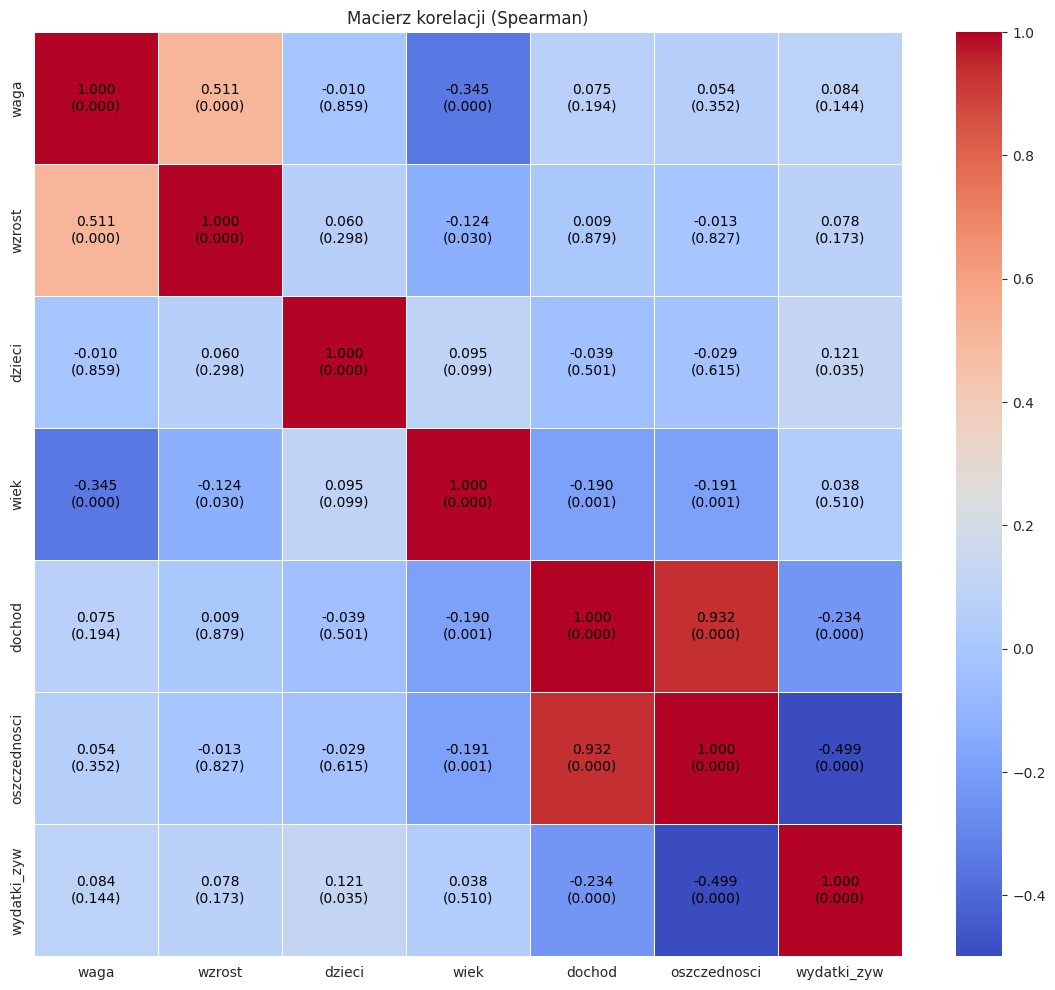

In [19]:
correlation_matrix_spearman, p_value_matrix = spearmanr(df[NUM_FEATURES])

correlation_matrix_spearman = pd.DataFrame(correlation_matrix_spearman, columns=df[NUM_FEATURES].columns, index=df[NUM_FEATURES].columns)
p_value_matrix = pd.DataFrame(p_value_matrix, columns=df[NUM_FEATURES].columns, index=df[NUM_FEATURES].columns)

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_spearman, annot=False, fmt=".3f", cmap='coolwarm', linewidths=0.5)
for i in range(len(correlation_matrix_spearman)):
    for j in range(len(correlation_matrix_spearman)):
        correlation = correlation_matrix_spearman.iloc[i, j]
        p_value = p_value_matrix.iloc[i, j]
        plt.text(j+0.5, i+0.5, f"{correlation:.3f}\n({p_value:.3f})", ha='center', va='center', color='black')
        
plt.title('Macierz korelacji (Spearman)')
plt.show()

Następujące pary zmiennych są ze sobą skorelowane, $p$-wartość jest mniejsza niż przyjęty przez nas poziom istotności - odrzucamy hipotezę zerową o niezależności:
- (waga, wzrost):                        0.51 (Współczynnik korelacji Spearmana) ,
- (waga, wiek):                         -0.34,
- (wiek, oszczędności):                 -0.19,
- (wiek, dochód):                       -0.19,
- (dochód, oszczędności):                0.93,
- (dochód, wydatki na żywność):         -0.23,
- (oszczędności, wydatki na żywność):   -0.5.

W pozostałych parach, $p$-wartość jest większa niż przyjęty przez nas poziom istotności, więc nie mamy podstaw do odrzucenia hipotezy zerowej o niezależności.

Korelacje pomiędzy dochodem a oszczędnościami oraz wagą a wzrostem wydają się być naturalne i zgodne z rzeczywistością.

## Analiza zależności pomiędzy zmiennymi jakościowymi

Aby sprawdzić, czy występują zależności pomiędzy zmiennymi jakościowymi, użyjemy testu niezależności $\chi^2$-Pearsona.


Stawiamy hipotezę zerową i alternatywną:

$$H_0: \; p_{ij} = p_{i.}p_{.j} \; \forall_{i, j} \quad \text{(niezależność zmiennych)}$$
$$H_1: \; p_{ij} \neq p_{i.}p_{.j}$$

Ustalamy poziom istotności $\alpha = 0.01$ i obliczmy $p$-wartość.

In [20]:
for cat_feature1 in CAT_FEATURES:
    for cat_feature2 in CAT_FEATURES:
        if cat_feature1 >= cat_feature2:
            continue

        contingency_table = pd.crosstab(index=df[cat_feature1], columns=df[cat_feature2])
        chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
        
        print(f"Sprawdzamy korelację {cat_feature1} z {cat_feature2}.")
        print(f"Wartość statystyki testowej: {chi2_stat}")
        print(f"P-wartość: {p_value}\n")

Sprawdzamy korelację jednoos z plec.
Wartość statystyki testowej: 0.13841187645610253
P-wartość: 0.7098649541109077

Sprawdzamy korelację jednoos z miejsce.
Wartość statystyki testowej: 0.5238551616221235
P-wartość: 0.7695667530897057

Sprawdzamy korelację miejsce z plec.
Wartość statystyki testowej: 2.9973658607422933
P-wartość: 0.22342423171950018



Widzimy, że w każdym z trzech testów, które przeprowadziliśmy, $p$-wartość jest zdecydowanie większa niż przyjęty przez nas poziom istotności.
 
Zatem nie mamy podstaw do odrzucenia hipotezy zerowej (niezależność zmiennych).

# Zadanie 3
## 3.1)
### Wykresy rozrzutu dla zmiennych ilościowych względem wydatków na żywność

In [21]:
num_rows = len(NUM_FEATURES) // 2
fig = sp.make_subplots(rows=num_rows, cols=num_cols)

for i, num_feature in enumerate(NUM_FEATURES, start=1):
    if num_feature != 'wydatki_zyw':
        fig.add_trace(
            go.Scatter(x=df['wydatki_zyw'], y=df[num_feature], mode='markers', name=num_feature),
            row=(i-1)//num_cols+1, col=(i-1)%num_cols+1
        )
        fig.update_yaxes(title_text=f'{num_feature}', row=(i-1)//num_cols+1, col=(i-1)%num_cols+1)
        fig.update_xaxes(title_text='Wydatki na żywność', row=(i-1)//num_cols+1, col=(i-1)%num_cols+1)

fig.update_layout(height=500*num_rows, width=1400, title_text="Wykresy rozrzutu zmiennych ilościowych względem wydatków na żywność")
fig.show()

Poczyńmy następujące obserwacje:
- Wraz ze wzrostem wagi, rosną maksymalne wydatki na żywność.
- Tylko 2 z 11 osób o wzroście powyżej 185 centymetrów mają wydatki na żywność mniejsze niż 220 bajtalarów.
- Wraz ze wzrostem liczby dzieci, zmniejsza się liczba respondentów z niższymi wydatkami na żywność.
- Niskie oszczędności wydają się być powiązane z dużymi wydatkami na żywność, ale wraz ze wzrostem oszczędności, wydatki na żywność rozkładają się bardziej równomiernie.
- Podobne zależności widzimy na wykresie wykresie dochodu i wydatków na żywność.
- Wykresy pozostałych zmiennych względem wydatków na żywność zmiennych przypominają chmurę, więc nie sugerują liniowej zależności między wydatkami na żywność.

## 3.2)
### Wykres pudełkowy dla wagi respondentów w podziale na miejsce zamieszkania

In [22]:
fig = px.box(df, x='miejsce', y='waga')
fig.update_layout(height=600, width=1400, title_text="Wykres pudełkowy dla wagi respondentów w podziale na miejsce zamieszkania")
fig.show()

Poczyńmy następujące obserwacje:
- Wraz ze wzrostem liczby mieszkańców w mieście maleje trzeci kwartyl wagi.
- Mediana utrzymuje się na podobnym poziomie w okolicy 80 kilogramów.
- Wraz ze wzrostem liczby mieszkańców w mieście rośnie minimalna waga. 
- Maksymalna waga utrzymuje się na podobnym poziomie w okolicy 86 kilogramów.
- $IQR = Q_3 - Q_1$ maleje wraz ze wzrostem liczby mieszkańców w mieście,
- Najmnieszą wagę ma respondent pochodzący z małej miejscowości, natomiast największą z średniej.

## 3.3)
## Wykres słupkowy skumulowany dla płci respondenta i faktu, czy prowadzi jednoosobowe gospodarstwo domowe

In [23]:
dfg = df.groupby(['plec', 'jednoos']).size().unstack(fill_value=0)

fig = px.bar(dfg, barmode='stack',
             title='Wykres słupkowy skumulowany dla płci respondenta i faktu, czy prowadzi jednoosobowe gospodarstwo domowe',
             labels={'jednoos': 'Prowadzi jednoosobowe gospodarstwo domowe', 'plec': 'Płeć', 'value': 'Liczba osób'},
             )
fig.show()

Poczyńmy następujące obserwacje:
- prawie 60% kobiet (97 osób) żyje w gospodarstwach wieloosobowych,
- pozostałe kobiety (66 osób) prowadzą jednoosobowe gospodarstwa domowe,
- prawie 57% mężczyzn (80 osób) żyje w gospodarstwach wieloosobowych,
- pozostali mężczyźni (61 osób) prowadzą jednoosobowe gospodarstwa domowe.

## 3.4)
### Dodatkowa analiza eksploracyjna

Zwizualizujemy na wykresie rozrzuty par zmiennych z kolorem odpowiadającym wydatkom na żywność.

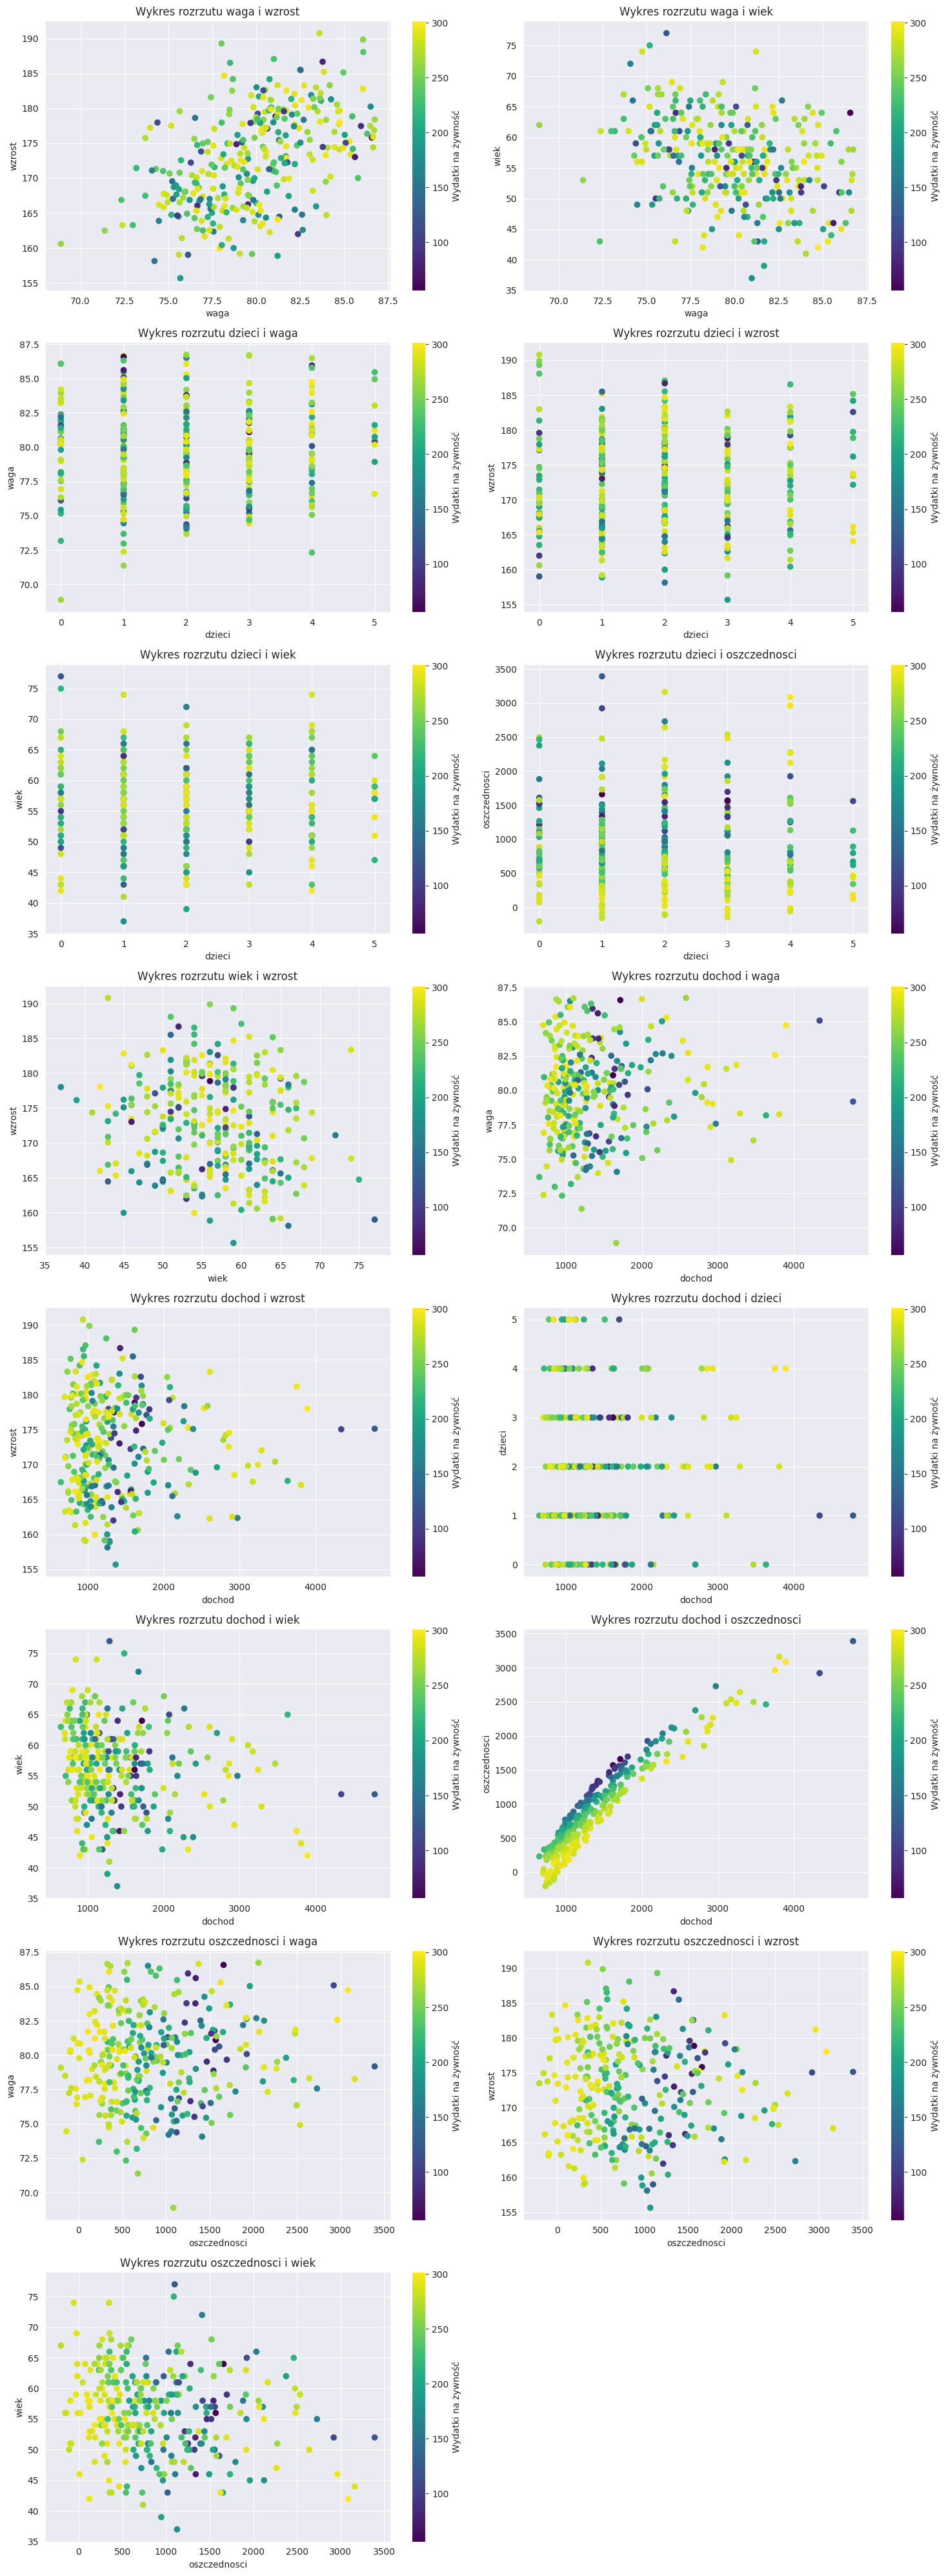

In [24]:
n = 15
num_rows = (n + 1) // 2
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows*5))

i = 0
colors = df['wydatki_zyw']

for num_feature1 in NUM_FEATURES:
    for num_feature2 in NUM_FEATURES:
        if num_feature1 == 'wydatki_zyw' or num_feature2 == 'wydatki_zyw' or num_feature1 >= num_feature2:
            continue

        x = df[num_feature1]
        y = df[num_feature2]

        ax = axs.flatten()[i]
        scatter = ax.scatter(x, y, c=colors, cmap='viridis')
        ax.set_title(f'Wykres rozrzutu {num_feature1} i {num_feature2}')
        ax.set_xlabel(f'{num_feature1}')
        ax.set_ylabel(f'{num_feature2}')
        fig.colorbar(scatter, ax=ax, label='Wydatki na żywność')

        i += 1

if n < num_rows * num_cols:
    for ax in axs.flatten()[n:]:
        fig.delaxes(ax)

plt.tight_layout()
plt.show()

Bardzo ciekawie wygląd wykres rozrzutu dochodu i oszczędności względem wydatków na żywność, ponieważ widzimy trzy linie trendu i każda z nich jest innego koloru. 

Wraz ze wzrostem oszczędności w stosunku do dochodu maleją wydatki na żywność.

W związku z tym możemy przedstawić na wykresie proporcję oszczędności względem dochodu i wydatki na żywność.

Na pozostałych wykresach nie obserwujemy zależności względem wydatków na żywność.

In [25]:
savings_by_income = df.copy()
savings_by_income['oszczednosci/dochod'] = savings_by_income['oszczednosci'] / savings_by_income['dochod']

fig = px.scatter(savings_by_income, x='oszczednosci/dochod', y='wydatki_zyw', labels={'wydatki_zyw':'wydatki na żywność'})
fig.show()

Poczyńmy następujące obserwacje:
- Zauważalny jest trend, wraz ze wzrostem proporcji oszczędności i dochódu (w szczególności powyżej 0.6) wydatki na żywbość zaczynają maleć.
- Jeżeli proporcja jest mniejsza niż 0.6, to wydatki na żywność są równe co najmniej 200 bajtalarów, a przeważnie powyżej 250 bajtalarów.

Nie satysfakcjonuje nas kolejna nieliniowa zależność, więc przetestujmy różnicę dochodu i oszczędności.

In [26]:
income_savings = df.copy()
income_savings['dochod-oszczednosci'] = (income_savings['dochod'] - income_savings['oszczednosci'])

fig = px.scatter(income_savings, x='dochod-oszczednosci', y='wydatki_zyw', labels={'wydatki_zyw':'wydatki na żywność'})
fig.show()

Zauważmy, że wykres przypomina półkole o środku 800. Wobec tego spróbujmy tak przetransformować naszą oś $x :=$ dochód - oszczędności. Mamy:

$z = (x - 800) ^ 2$


In [27]:
income_savings['z'] = (income_savings['dochod-oszczednosci'] - 800) ** 2

fig = px.scatter(income_savings, x='z', y='wydatki_zyw', labels={'wydatki_zyw':'wydatki na żywność', 'z':'(dochód - oszczędności - 800)^2'})
fig.show()

Otrzymaliśmy malejącą zależność liniową, więc zwizualizujmy dla przejrzystości jeszcze $-z$:

In [28]:
income_savings['-z'] = -income_savings['z']

fig = px.scatter(income_savings, x='-z', y='wydatki_zyw', labels={'wydatki_zyw':'wydatki na żywność', '-z':'-(dochód - oszczędności - 800)^2'})
fig.show()

Otrzymaliśmy zależność liniową wobec wydatków na żywność, czyli naszej zmiennej objaśnianej.

Napewno przyda nam się ona do ostatecznego, "najlepszego" modelu.

Sprawdźmy jeszcze jak wygląda rozkład BMI (Body Mass Index) w naszej próbie. 

In [29]:
bmi_series = df['waga'] / ((df['wzrost'] / 100)**2)
fig = go.Figure(data=[go.Histogram(x=bmi_series, nbinsx=50)])
fig.update_layout(title_text="Histogram BMI w próbie", xaxis_title="BMI", yaxis_title="Liczba osób")
fig.show()

Rozkład BMI w naszej próbie przypomina rozkład normalny.

Użyjemy testu Shapiro-Wilka, aby to sprawdzić.

Stawiamy hipotezę zerową i alternatywną:

$$ H_0: \; \text{Zmienna BMI pochodzi z populacji o rozkładzie normalnym.} $$
$$ H_1: \; \text{Zmienna BMI nie pochodzi z populacji o rozkładzie normalnym.} $$

Ustalamy poziom istotności $\alpha = 0.01$ i obliczmy $p$-wartość.

In [30]:
stat, p_value = shapiro(bmi_series)

print(f"Wartość statystyki testowej: {stat}")
print(f"P-wartość {p_value}")

Wartość statystyki testowej: 0.9936730677669612
P-wartość 0.23303271925478664


Widzimy, że $p$-wartość jest zdecydowanie większa niż przyjęty przez nas poziom istotności.
 
Zatem nie mamy podstaw do odrzucenia hipotezy zerowej (BMI pochodzi z populacji o rozkładzie normalnym).

# Zadanie 4
## 4.1)

W przypadku średniej oraz odchylenia standardowego użyjemy przedziałów ufności dla zmiennej z rozkładu normalnego o nieznanej średniej oraz wariancji. Założenia te wydają się być spełnione, ponieważ w pierwszym zadaniu wizualnie oceniliśmy, że wiek może pochodzić z populacji o rozkładzie normalnym oraz test Shapiro-Wilka nie odrzucił hipotezy o normalności. 

Założenia $X_1, \cdots , X_n$ jest losową próbką z $N(\mu, \sigma^2)$. Nie znamy $\mu$ i $\sigma$. Z wykładu wiemy, że przedziały ufności dla $\hat{\mu}$ są następujące:

$$\left (\hat{\mu} - t_{1-\alpha/2, N-1}\frac{\hat{\sigma}}{\sqrt{N}},\quad \hat{\mu} + t_{1-\alpha/2, N-1}\frac{\hat{\sigma}}{\sqrt{N}} \right ), $$

gdzie $t_{1-\alpha/2, N-1}$ jest kwantylem rozkładu $t$-Studenta z $N-1$ stopniami swobody na poziomie $1-\alpha/2$ oraz
 $\hat{\sigma} = \sqrt{\sum_{i=1}^N (X_i - \bar{X})^2/(N-1)}$, gdzie $\bar{X} = \hat{\mu} = \sum_{i=1}^N X_i/N$.


In [31]:
N = len(df['wiek'])
age_mean = np.mean(df['wiek']) 
age_std_hat = np.sqrt( np.sum((df['wiek'] - age_mean) ** 2) / (N - 1) )

t = tstud.ppf(1 - alpha/2, N - 1)
segment_size = t * (age_std_hat / np.sqrt(N))

print(f"Średnia w próbie: {age_mean}")
print(f"Przedział ufności dla średniej: [{age_mean - segment_size}, {age_mean + segment_size}]")

Średnia w próbie: 56.25986842105263
Przedział ufności dla średniej: [55.25152156054645, 57.26821528155881]


Założenia $X_1, \cdots , X_n$ jest losową próbką z $N(\mu, \sigma^2)$. Nie znamy $\mu$ i $\sigma$. Z wykładu wiemy, że przedziały ufności dla $\hat{\sigma}^2$ są następujące:

$$\left( \frac{nS_n^2}{\chi^2_{(1-\frac{\alpha}{2}), n-1} }, \frac{nS_n^2}{\chi^2_{(\frac{\alpha}{2}), n-1} } \right ), $$

gdzie $\chi^2_{\alpha, n-1}$ jest kwantylem rozkładu $\chi^2$ z $N-1$ stopniami swobody na poziomie $\alpha$ oraz
 $S_n = {\sum_{i=1}^N (X_i - \bar{X})^2/(N)}$, gdzie $\bar{X} = \hat{\mu} = \sum_{i=1}^N X_i/N$.
 
Żeby otrzymać przedział ufności dla odchylenia standardowego, wystarczy wziąć pierwiastek z lewego i prawego końca przedziału.

In [32]:
chi2_left = chi2.ppf(1 - alpha / 2, N - 1)
chi2_right = chi2.ppf(alpha / 2, N - 1)

S2_n = np.var(df['wiek'])

left_bound = (N * S2_n) / chi2_left
right_bound = (N * S2_n) / chi2_right

print(f"Odchylenie standardowe w próbie: {np.sqrt(S2_n)}")
print(f"Przedział ufności dla odchylenia standardowego: [{np.sqrt(left_bound)}, {np.sqrt(right_bound)}]")

Odchylenie standardowe w próbie: 6.771279905721986
Przedział ufności dla odchylenia standardowego: [6.136394836972781, 7.568207600724594]


## 4.2)
Skorzystamy z asymptotycznych przedziałów ufności do obliczenia przedziałów ufności dla kwartyli:

Niech $\theta_1, \theta_2, \theta_3$ oznaczają kwartyle $1, 2$ i $3$. Dla $i \in \{1, 2, 3\}$ mamy: 

$\sqrt{n} (\hat{\theta_i} - \theta_i) \approx N(0, \sigma_i^2)$

Wtedy $\theta_i \in \left( \hat{\theta_i} - q_{(1-\alpha/2)} \cdot \frac{\sigma_i}{\sqrt{n}}, \hat{\theta_i} + q_{(1-\alpha/2)} \cdot \frac{\sigma_i}{\sqrt{n}} \right)$

Ponieważ $n$ - liczba obserwacji jest dość duża oraz nasza próbka jest reprezentatywna, to możemy powołać się na CTG i skorzystać z asymptotycznych przedziałów ufności.

Nie znamy jednak odchylenia standradowego estymatora kwartyli, więc skorzystamy z metody bootstrap, aby go przybliżyć.

In [33]:
B = 10_000

bootstrap_quantiles = []

for _ in range(B):
    sample = df.sample(replace=True, n=N)
    sample_quantiles = np.percentile(sample['wiek'], [25, 50, 75], axis=0)
    bootstrap_quantiles.append(sample_quantiles)

std_estimates = np.std(bootstrap_quantiles, axis=1, ddof=1)
Q1, Q2, Q3 = np.percentile(df['wiek'], [25, 50, 75])
q_stat = stats.norm.ppf(1 - alpha / 2)

CI1 = [Q1 - q_stat * std_estimates[0] / np.sqrt(N), Q1 + q_stat * std_estimates[0] / np.sqrt(N)]
CI2 = [Q2 - q_stat * std_estimates[1] / np.sqrt(N), Q2 + q_stat * std_estimates[1] / np.sqrt(N)]
CI3 = [Q3 - q_stat * std_estimates[2] / np.sqrt(N), Q3 + q_stat * std_estimates[2] / np.sqrt(N)]

print(f"Kwartyl 1 w próbie: {Q1}")
print(f"Przedział ufności dla kwartylu 1: {CI1}")

print(f"Kwartyl 2 w próbie: {Q2}")
print(f"Przedział ufności dla kwartylu 2: {CI2}")

print(f"Kwartyl 3 w próbie: {Q3}")
print(f"Przedział ufności dla kwartylu 1: {CI3}")

Kwartyl 1 w próbie: 51.75
Przedział ufności dla kwartylu 1: [51.01133028750129, 52.48866971249871]
Kwartyl 2 w próbie: 56.5
Przedział ufności dla kwartylu 2: [55.756422129104756, 57.243577870895244]
Kwartyl 3 w próbie: 61.0
Przedział ufności dla kwartylu 1: [60.26133028750129, 61.73866971249871]


# Zadanie 5
Na początku przeprowadzimy podział i utworzymy cztery pomocnicze ramki danych.

In [34]:
class_names = ['klasa niższa', 'klasa średnia', 'klasa wyższa średnia', 'klasa wyższa']

class_quantiles = [.25, .75, .90]

df_with_classes = df.copy()
income_quantiles = df_with_classes['dochod'].quantile(class_quantiles)
print(income_quantiles)

df_with_classes['klasa_zamoznosci'] = pd.cut(df_with_classes['dochod'], 
                                bins=[-float('inf'), income_quantiles[.25], income_quantiles[.75], income_quantiles[.90], float('inf')], 
                                labels=class_names)

0.25     965.8300
0.75    1613.9475
0.90    2194.5270
Name: dochod, dtype: float64


Zwizualizujemy wydatki na żywność w poszczególnych klasach zamożności.

In [35]:
fig = sp.make_subplots(rows=2, cols=2)

for i, income_class in enumerate(class_names, start=0):
    fig.add_trace(
        go.Histogram(x=df_with_classes[df_with_classes['klasa_zamoznosci'] == income_class]['wydatki_zyw'], 
                     name=income_class, nbinsx=30),
        row=i//2+1, col=i%2+1 
    )
    fig.update_yaxes(title_text=income_class, row=i//2+1, col=i%2+1)
    fig.update_xaxes(title_text='Wydatki na żywność', row=i//2+1, col=i%2+1)


fig.update_layout(height=1000, width=1400, title_text="Rozkład wydatków na żywność w podziale na klasy zamożności")
fig.show()

Jako miarę zróżnicowania wybrałem współczynnik zmienności (coefficient of variation). Jest on niezależny od jednostek i wartości średniej, więc będzie tutaj dobrym wyborem. 

Korzystamy z następującego wzoru:

$$\text{cv}(X) = \text{sd}(X)/\mathbb{E}(X)$$

In [36]:
def coefficient_of_variation(class_name):
    class_spending = df_with_classes[df_with_classes['klasa_zamoznosci'] == class_name]['wydatki_zyw'] 
    return np.std(class_spending) / np.mean(class_spending)

for _class_name in class_names:
    print(f"Współczynnik zmienności (coefficient of variation) dla {_class_name}: {coefficient_of_variation(_class_name)}")

Współczynnik zmienności (coefficient of variation) dla klasa niższa: 0.12035966256405885
Współczynnik zmienności (coefficient of variation) dla klasa średnia: 0.25580700269490003
Współczynnik zmienności (coefficient of variation) dla klasa wyższa średnia: 0.3232600732360283
Współczynnik zmienności (coefficient of variation) dla klasa wyższa: 0.22080648947815684


W klasie wyższej średniej wydatki na żywność mają największy współczynnik zmienności. Oznacza to, że wydatki są tam najbardziej zróżnicowane.

Następnie, w kolejności malejącego współczynnika zmienności, mamy klasę średnią oraz wyższą, gdzie obserwujemy średnie współczynniki zmienności, co oznacza umiarkowane zróżnicowanie wydatków na żywność.

W klasie niższej współczynnik zmienności jest najmniejszy, więc wnioskujemy, że wydatki na żywność są tam najbardziej zrównoważone.

Na koniec zwizualizujemy wydatki na żywność w poszczególnych klasach zamożności na krzywej Lorenza.

Im bliżej przekątnej wykresu tym rozkład zarobków jest bardziej równomierny.

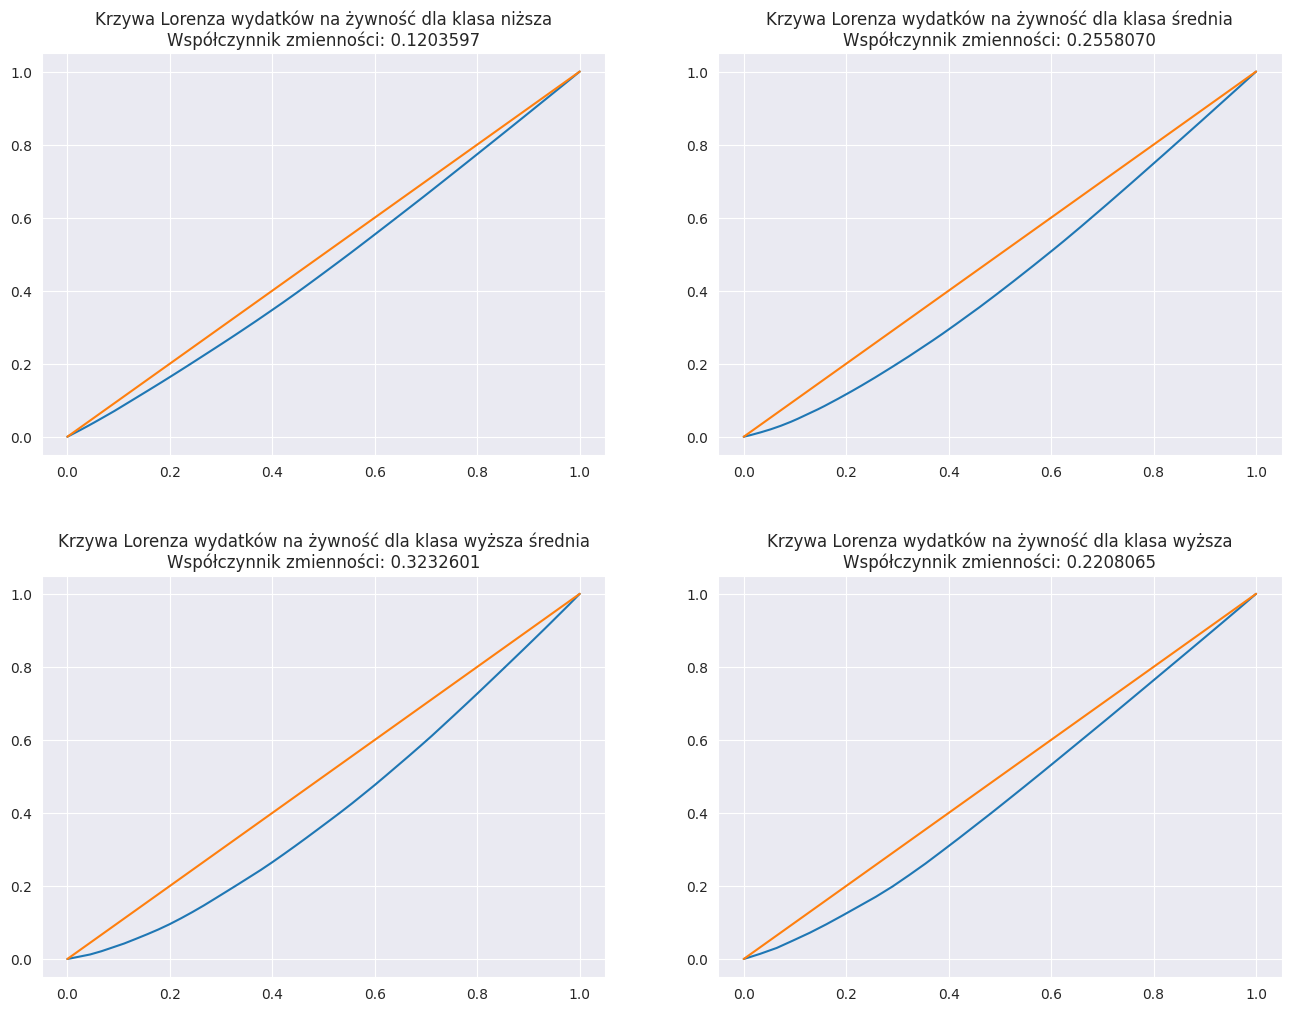

In [37]:
# https://zhiyzuo.github.io/Plot-Lorenz/
def lorenz(arr):
    scaled_prefix_sum = arr.cumsum() / arr.sum()
    return np.insert(scaled_prefix_sum, 0, 0)

def plot_lorenz():
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.3)

    for i, class_name in enumerate(class_names, start=0):
        class_spending = df_with_classes[df_with_classes['klasa_zamoznosci'] == class_name]['wydatki_zyw'] 
        class_spending = np.array(np.sort(class_spending))

        lorenz_curve = lorenz(class_spending)
        ax = axs.flatten()[i]

        ax.plot(np.linspace(0.0, 1.0, lorenz_curve.size), lorenz_curve)
        ax.plot([0,1], [0,1])
        ax.set_title(f"Krzywa Lorenza wydatków na żywność dla {class_name}\nWspółczynnik zmienności: {coefficient_of_variation(class_name):.7f}")

    plt.show()
    
plot_lorenz()

Widzimy, że odchylenie od przekątnej pokrywa się ze współczynnikiem zmienności (im większy współczynnik, tym bardziej widoczne jest odchylenie). 

# Zadanie 6
## 6.1) 
Na początku zwizualizujemy oszczędności mężczyzn i kobiet na histogramach.

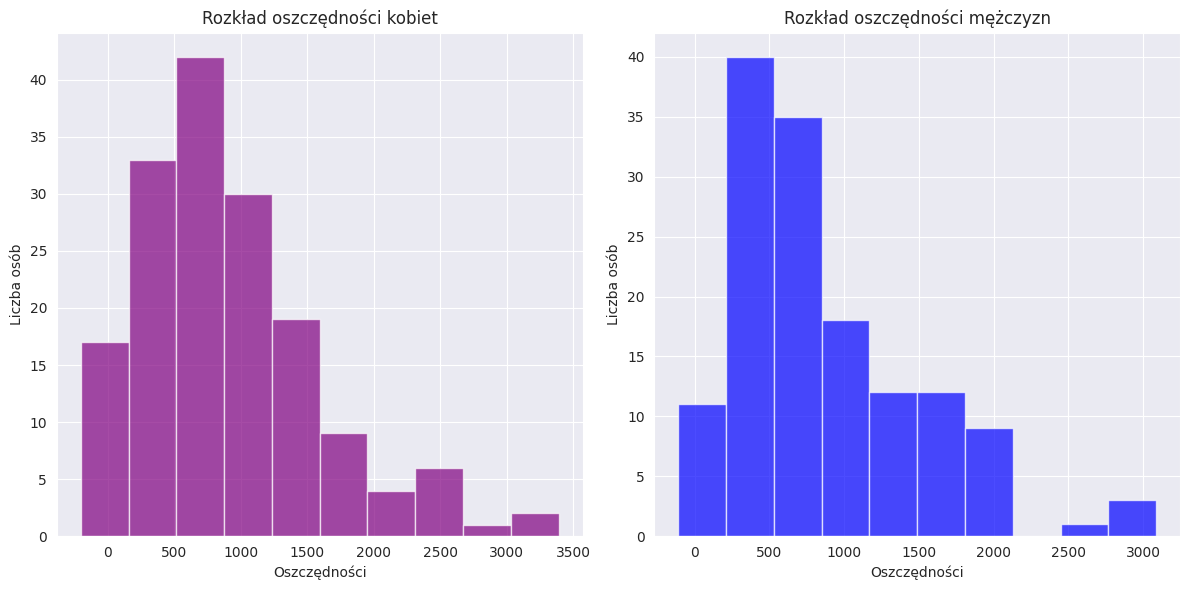

In [38]:
savings_women = df[df['plec'] == 1]['oszczednosci']
savings_men = df[df['plec'] == 2]['oszczednosci']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(savings_women, color='purple', alpha=0.7, label='Kobiety')
plt.xlabel('Oszczędności')
plt.ylabel('Liczba osób')
plt.title('Rozkład oszczędności kobiet')

plt.subplot(1, 2, 2)
plt.hist(savings_men, color='blue', alpha=0.7, label='Mężczyźni')
plt.xlabel('Oszczędności')
plt.ylabel('Liczba osób')
plt.title('Rozkład oszczędności mężczyzn')

plt.tight_layout() 
plt.show()

Dodatkowo, zwizualizujmy sobie rozkłady na wykresie kwantyl-kwantyl, żeby zdecydować czy możemy użyć testu t, czy też jego nieparametrycznej alternatywy. 

W tytule dodałem również $p$-wartość z testu Shapiro-Wilka.

/tmp/ipykernel_25960/1398190543.py:14: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



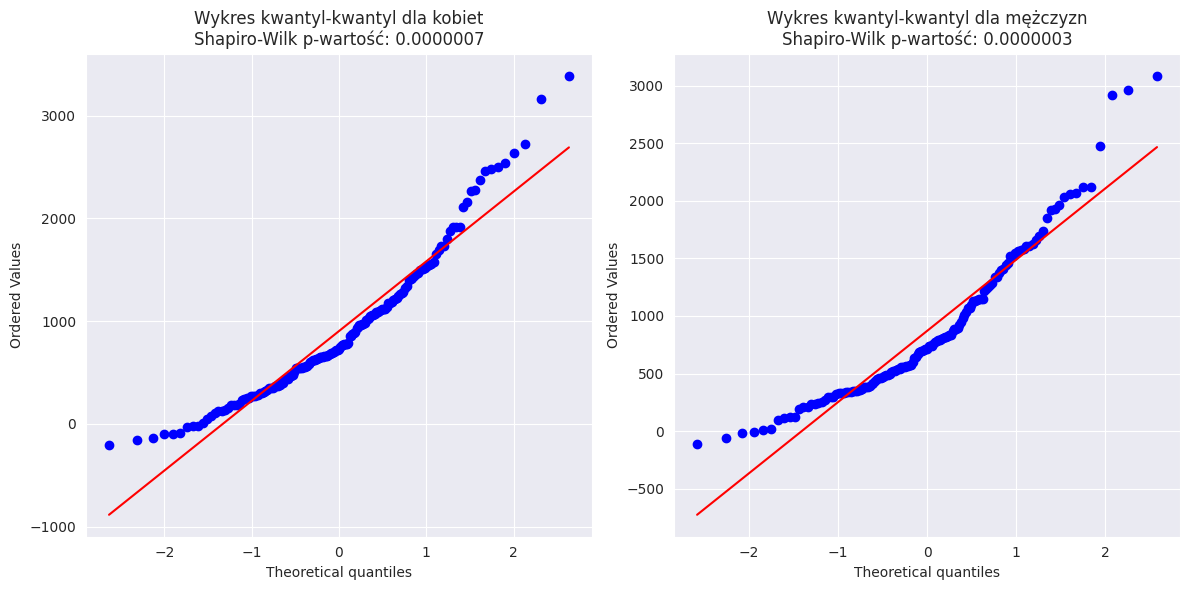

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

stat_women, p_women = shapiro(savings_women)
stats.probplot(savings_women, dist='norm', plot=axs[0])
axs[0].set_title(f'Wykres kwantyl-kwantyl dla kobiet\nShapiro-Wilk p-wartość: {p_women:.7f}')
axs[0].grid(True)

stat_men, p_men = shapiro(savings_men)
stats.probplot(savings_men, dist='norm', plot=axs[1])
axs[1].set_title(f'Wykres kwantyl-kwantyl dla mężczyzn\nShapiro-Wilk p-wartość: {p_men:.7f}')
axs[1].grid(True)

fig.tight_layout() 
fig.show()

Widzimy znaczące odstępstwa na wykresach oraz $p$ wartość jest niższa niż przyjęty przez nas poziom istotności ($\alpha = 0,01$).

Wobec tego odrzucamy hipotezę zerową o normalności, więc skorzystamy z nieparametrycznego testu Mann-Whitney U.

Na początku przeprowadzimy test Levene, żeby sprawdzić czy wariancja oszczędności u kobiet 
jest równa wariancji oszczędności u mężczyzn.

Zdecydowałem się użyć testu Levene zamiast F-testu, ponieważ F-test jest bardzo wrażliwy na próbki, które nie pochodzą z rozkładu normalnego.

Stawiamy hipotezę zerową i alternatywną:

$$ H_0:\sigma_{1} = \sigma_{2} (\text{wariancje są równe}) $$
$$ H_1: \sigma_1 \ne \sigma_2 (\text{wariancje są różne}) $$

Ustalamy poziom istotności $\alpha=0.01$ i obliczamy $p$-wartość.

In [40]:
stat, p_value = stats.levene(savings_women, savings_men)

print(f"Wartość statystyki testowej: {stat}")
print(f"P-wartość: {p_value}")

Wartość statystyki testowej: 0.6786663488552399
P-wartość: 0.4106964476931546


$P$-wartość jest zdecydowanie większa niż ustalony poziom istotności. 

Zatem nie mamy podstaw do odrzucenia hipotezy zerowej - wariancje są równe.

Dla pewności, sprawdzimy jeszcze, czy przedziały ufności dla wariancji się przecinają:

In [41]:
def variance_confidence_intervals(savings):
    N = len(savings)
    chi2_left = chi2.ppf(1 - alpha / 2, N - 1)
    chi2_right = chi2.ppf(alpha / 2, N - 1)
    
    S2_n = np.var(savings)

    left_bound = (N * S2_n) / chi2_left
    right_bound = (N * S2_n) / chi2_right
    return left_bound, right_bound

print(f"Przedział ufności dla wariancji oszczędności kobiet: {variance_confidence_intervals(savings_women)}")
print(f"Przedział ufności dla wariancji oszczędności mężczyzn: {variance_confidence_intervals(savings_men)}")

Przedział ufności dla wariancji oszczędności kobiet: (369998.25340623123, 657335.382686998)
Przedział ufności dla wariancji oszczędności mężczyzn: (304799.31640354113, 565802.785786595)


Widzimy, że przedziały ufności dla wariancji oszczędności kobiet i mężczyzn przecinają się.

Zatem, możemy przejść do testu Mann-Whitney U, który jest w tym przypadku odpowiedni, ponieważ bada zachowanie median.

Musimy też pamiętać, żeby zachować ostrożność w interpretacji wyniku, ponieważ test ten cechuje niższa moc niż test $t$ dla prób niezależnych.

Stawiamy hipotezę zerową i alternatywną:

$$ H_0: P(X > Y) = P(Y > X) $$
$$ H_1: P(X > Y) > P(Y > X) $$
Ustalamy poziom istotności $\alpha=0.01$ i obliczamy $p$-wartość.

In [42]:
stat, p_value = stats.mannwhitneyu(savings_women, savings_men, alternative='greater')

print(f"Wartość statystyki testowej: {stat}")
print(f"P-wartość: {p_value}")

Wartość statystyki testowej: 11708.0
P-wartość: 0.3887370161711446


W teście Mann-Whitney U, który przeprowadziliśmy, wychodzi, że $p$-wartość jest zdecydowanie większa niż przyjęty przez nas poziom istotności. Zatem nie mamy podstaw do odrzucenia hipotezy zerowej. Mediany obu zmiennych nie różnią się w sposób istotny statystycznie.

Z przeprowadzonych przez nas testów wynika, że kobiety nie cechują się wyższymi wartościami oszczędności niż mężczyźni.

## 6.2)
Na początku zwizualizujemy na wykresie zależność proporcji wydatków na żywność względem dochodu i oszczędności.

In [43]:
spending_by_income = df['wydatki_zyw'] / df['dochod']

fig = px.scatter(df, x=spending_by_income, y='oszczednosci',
                 title='Zależność między proporcją wydatków na żywności względem dochodem i oszczędnościami',
                 labels={'x':'Proporcja wydatków na żywność względem dochodu', 'y':'Oszczędności'},
                 color_discrete_sequence=['purple'])

fig.update_layout(autosize=False, width=900, height=700)
fig.show()

Aby sprawdzić, czy występuje zależności pomiędzy proporcją wydatków na żywność względem dochodu a oszczędności, użyjemy ponownie współczynnika korelacji Spearmana. Współczynnik korelacji Pearsona znowu nie jest najlepszym wyborem ze względu na obserwowaną zależność nieliniową oraz występowanie obserwacji odstających. Na powyższym wykresie widzimy zależność monotoniczną między tymi zmiennymi, więc korelacja rangowa jest tutaj dobrym wyborem.

Stawiamy hipotezę zerową i alternatywną:

$$H_0: \; p_{ij} = p_{i.}p_{.j} \; \forall_{i, j} \quad \text{(niezależność zmiennych)}$$
$$H_1: \; p_{ij} \neq p_{i.}p_{.j}$$

Ustalamy poziom istotności $\alpha = 0.01$ i obliczmy $p$-wartość.


In [44]:
correlation, p_value = stats.spearmanr(spending_by_income, df['oszczednosci'])
print(f"Współczynnik korelacji spearmana: {correlation}")
print(f"P-wartość dla testu Spearmana: {p_value}")

Współczynnik korelacji spearmana: -0.9726091116445553
P-wartość dla testu Spearmana: 2.0103756749114015e-193


Widzimy, że $p$-wartość jest zdecydowanie niższa niż przyjęty przez nas poziom istotności oraz wartość współczynnika korelacji jest bliska $-0,97$.
 
Zatem odrzucamy hipotezę zerową (niezależność zmiennych), istnieje istotna korelacja pomiędzy proporcją wydatków na żywność względem dochodu a oszczędnościami.

Wartość współczynnika korelacji bliska -1 wskazuje na istotną ujemną zależność między proporcją wydatków na żywność względem dochodu a oszczędnościami. 

A zatem, niższa proporcja wydatków na żywność względem dochodu jest skorelowana z wyższymi oszczędnościami.

## 6.3)
Na początku zwizualizujemy wagę kobiet na histogramie oraz wykresie kwantyl-kwantyl. 

Porównanie z rozkładem normalnym jest koniecznie, żeby sprawdzić, czy będziemy mogli użyć jednostronnego testu t.

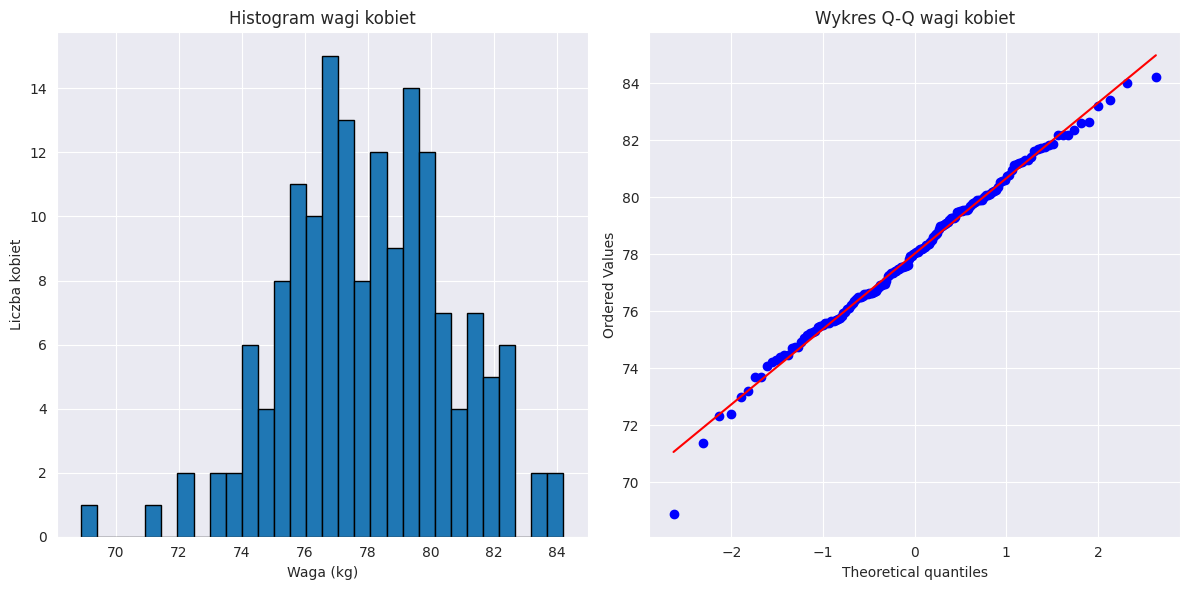

In [45]:
women_weight = df[df['plec'] == 1]['waga']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(women_weight, bins=30, edgecolor='black')
axs[0].set_title('Histogram wagi kobiet')
axs[0].set_xlabel('Waga (kg)')
axs[0].set_ylabel('Liczba kobiet')

stats.probplot(women_weight, plot=axs[1])
axs[1].set_title('Wykres Q-Q wagi kobiet')

plt.tight_layout()
plt.show()

Zarówno z histogramu jak i wykresu kwantyl-kwantyl możemy wywnioskować, że z dużym prawdopodobieństwem nasze dane pochodzą z rozkładu normalnego. Aby się upewnić przeprowadzimy jeszcze test Shapiro-Wilka.

Stawiamy hipotezę zerową i alternatywną:

$$H_0: \; \text{Waga kobiet pochodzi z populacji o rozkładzie normalnym.} $$
$$H_1: \; \text{Waga kobiet nie pochodzi z populacji o rozkładzie normlanyie normlanym.} $$

Ustalamy poziom istotności $\alpha = 0.01$ i obliczmy $p$-wartość.


In [46]:
W, p_val = stats.shapiro(women_weight)

print(f"Wartość statystyki W: {W}")
print(f"P-wartość: {p_val}")

Wartość statystyki W: 0.9934981133349365
P-wartość: 0.6817891257217605


Widzimy, że $p$-wartość jest zdecydowanie większa niż przyjęty przez nas poziom istotności. Zatem nie mamy podstaw do odrzucenia hipotezy zerowej (waga kobiet pochodzi z populacji o rozkładzie normalnym).

Skoro założenie o normalności jest spełnione, to możemy przejść do jednostronnego testu t-studenta.

Stawiamy hipotezę zerową i alternatywną:

$$H_0: \; \mu = 56 $$
$$H_1: \; \mu > 56 $$

Ustalamy poziom istotności $\alpha = 0.01$ i obliczmy $p$-wartość.

In [47]:
t_stat, p_value = stats.ttest_1samp(women_weight, 56, alternative='greater')

print(f"Statystyka testowa: {t_stat}")
print(f"P-wartość: {p_value}")

Statystyka testowa: 107.0286338796581
P-wartość: 1.5711163348632539e-152


Widzimy, że $p$-wartość jest zdecydowanie niższa niż przyjęty przez nas poziom istotności. Zatem odrzucamy hipotezę zerową.

Wnioskujemy, że średnia waga kobiet w populacji jest wyższa niż 56 kg.

## 6.4)

Zweryfikujemy następującą hipotezę:

Liczba dzieci ma rozkład Poissona z parametrem 2.

Na początku porównajmy wizualnie rozkłady:

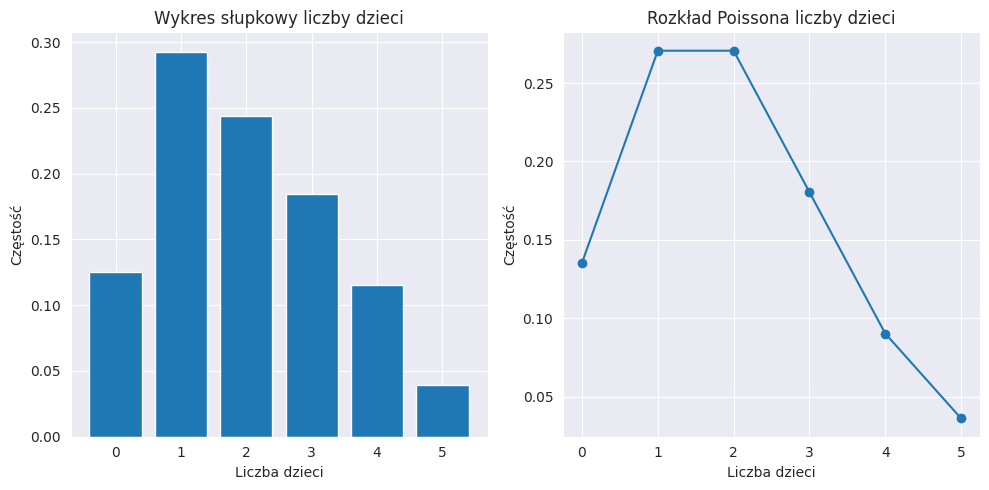

In [48]:
num_children = df['dzieci']

lambda_ = 2

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].bar(np.arange(num_children.min(), num_children.max()+1), np.bincount(num_children, minlength=num_children.max()+1) / len(num_children))
axs[0].set_title('Wykres słupkowy liczby dzieci')
axs[0].set_xlabel('Liczba dzieci')
axs[0].set_ylabel('Częstość')

x = np.arange(num_children.min(), num_children.max() + 1)
y = np.exp(-lambda_) * lambda_**x / np.array([math.factorial(k) for k in x])
axs[1].plot(x, y, 'o-')
axs[1].set_title('Rozkład Poissona liczby dzieci')
axs[1].set_xlabel('Liczba dzieci')
axs[1].set_ylabel('Częstość')

plt.tight_layout()
plt.show()

Ponieważ, maksymalna liczba dzieci wynosi 5, to zmienimy klasę 5 w 5+.

Prawdopodobieństwo przyjęcia wartości z klasy $5+$ jest równe 1 - suma prawdopodobieństw z klas $[0,\ldots,4]$

Przechodzimy do testu $\chi^2$-Pearsona (zgodności), który sprawdza zgodność rozkładu z próby z rozkładem hipotetycznym.

Liczebności w klasach nie są bardzo niskie $\leq 5$, więc test $\chi^2$-Pearsona jest tutaj odpowiednim wyborem.

W naszym przypadku sprawdzamy czy liczba dzieci ma rozkład Poissona z parametrem $\lambda = 2$:

Niech $f(k) = e^{-\lambda} \frac{\lambda^k}{k!} $, $f(5+) = 1 - \sum_{i=0}^4 f(i) $ oraz $p_0 = (f(0), f(1), \ldots, f(4), f(5+))$.

Stawiamy hipotezę zerową oraz alternatywną:

$$ H_0: p = p_0 $$
$$ H_1: p \neq p_0 $$

Ustalamy poziom istotności $\alpha = 0.01$ i obliczmy $p$-wartość.

In [49]:
# Liczebność w poszczególnych klasach.
children_frequencies = [num_children.value_counts()[i] for i in range(6)]

# Oczekiwane liczebności klas są równe n * f(i).
expected_frequencies = [ np.exp(-lambda_) * lambda_**k / math.factorial(k) for k in range(5)] 
expected_frequencies.append(1 - np.sum(expected_frequencies))
expected_frequencies = [len(num_children) * frequency for frequency in expected_frequencies]

print(f"Liczebność klas w próbie: {children_frequencies}")
print(f"Oczekiwana liczebność klas: {expected_frequencies}\n")

chi2_stat, p_value = stats.chisquare(children_frequencies, f_exp=expected_frequencies)

print(f"Wartość statystyki chi-kwadrat: {chi2_stat}")
print(f"P-wartość: {p_value}")

Liczebność klas w próbie: [38, 89, 74, 56, 35, 12]
Oczekiwana liczebność klas: [41.14192610393026, 82.28385220786052, 82.28385220786052, 54.85590147190702, 27.42795073595351, 16.006517272488168]

Wartość statystyki chi-kwadrat: 4.739229645336585
P-wartość: 0.44852641359061884


Widzimy, że $p$-wartość jest zdecydowanie wyższa niż przyjęty przez nas poziom istotności. Zatem nie mamy podstaw do odrzucenia hipotezę zerowej. 

Liczba dzieci na utrzymaniu respondenta może mieć rozkład Poissona z parametrem 2.

# Zadanie 7
## 7.1)

Na początku rozkodujemy zmienne jakościowe.

In [50]:
def encode_categorical(df_to_encode):
    df_to_encode['plec'] = df_to_encode['plec'].map({1: 'kobieta', 2: 'mezczyzna'})
    df_to_encode['miejsce'] = df_to_encode['miejsce'].map({1: 'male', 2: 'srednie', 3: 'duze'})

    df_to_encode = pd.get_dummies(df_to_encode, drop_first=True, dtype=int)
    return df_to_encode

Oszacowujemy wstępny model.

In [51]:
df_copy = df.copy()
df_encoded = encode_categorical(df_copy)

y = df_encoded['wydatki_zyw']
X = df_encoded.drop(['wydatki_zyw'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            wydatki_zyw   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     61.90
Date:                Sun, 12 May 2024   Prob (F-statistic):           2.51e-66
Time:                        18:59:52   Log-Likelihood:                -1488.6
No. Observations:                 304   AIC:                             2999.
Df Residuals:                     293   BIC:                             3040.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             226.7259     90.897     

## 7.2)
***$R^2$ (R-kwadrat)***

Wartość $R^2$ wynosi 0.679, co oznacza, że około 67.9% zmienności wydatków na żywność jest wyjaśnione przez predyktory użyte w modelu.

Jest to dość wysoka wartość, co sugeruje, że model jest dobrze dopasowany do danych, ale możemy go poprawić.

***Test łącznej istotności (F-statistic):***
 
$P$-wartość jest zdecydowanie niższa niż przyjęty przez nas poziom istotności.

Oznacza to, że odrzucamy hipotezę zerową. Wstępny model jest istotny statystycznie.

***Testy indywidualnej istotności (t-tests):***

Zmienne, dla których $p$-wartość jest zdecydowanie większa niż przyjęty poziom istotności, mogą być kandydatami do usunięcia w celu poprawy modelu. 

Są to:
- waga,
- wzrost,
- wiek,
- płeć,
- miejsce zamieszkania (zarówno małe jak i średnie miejscowości),
- status gospodarstwa domowego.

Zmienne, które mają znaczący wpływ na predykcję naszego modelu ($p$-wartość jest niższa niż przyjęty przez nas poziom istotności):
- dochód,
- oszczędności.

## 7.3)
Funkcja pomocnicza do analizy liniowości formy funkcyjnej.

In [52]:
def plot_residuals_vs_fitted(regression_results):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    model_residuals = regression_results.resid
    model_fitted_y = regression_results.fittedvalues

    axs[0].scatter(model_fitted_y, model_residuals)
    axs[0].axhline(0, color='red')
    axs[0].set_title('1. Wykres reszt vs wartości dopasowanych')
    axs[0].set_xlabel('Wartości dopasowane')
    axs[0].set_ylabel('Reszty')
    axs[0] = sns.regplot(x=model_fitted_y, y=model_residuals,
                                    scatter=True,
                                    ci=False,
                                    lowess=True,
                                    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    axs[1].set_title('2. Wykres reszt vs wartości dopasowanych')
    axs[1].set_xlabel('Wartości dopasowane')
    axs[1].set_ylabel('Reszty')

    plt.tight_layout()
    plt.show()

Funkcja pomocnicza do analizy homoskedastyczności oraz autokorelacji składnika losowego. 

In [53]:
def plot_residuals_vs_index(regression_results):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    model_fitted_y = regression_results.fittedvalues
    model_residuals = regression_results.resid

    axs[0].plot(range(len(model_residuals)), model_residuals, marker='o', linestyle='-', color='b')
    axs[0].axhline(0, color='red', linestyle='--')
    axs[0].set_title('3. Reszty vs numer obserwacji')
    axs[0].set_xlabel('Numer obserwacji')
    axs[0].set_ylabel('Reszty')

    model_norm_residuals = regression_results.get_influence().resid_studentized_internal
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

    sns.regplot(x=model_fitted_y, y=model_norm_residuals_abs_sqrt,
                scatter=True,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    axs[1].set_title('4. Wykres Skalowanych Reszt')
    axs[1].set_xlabel('Wartości dopasowane')
    axs[1].set_ylabel('$\sqrt{|Standaryzowane reszty|}$')

    plt.tight_layout()
    plt.show()

Funkcja pomocnicza do analizy rozkładu reszt składnika losowego.

In [54]:
def plot_residuals_distribution(regression_results):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    model_residuals = regression_results.resid
    
    axs[0].hist(model_residuals, bins=30, edgecolor='black')
    axs[0].set_title('5. Histogram reszt')
    axs[0].set_xlabel('Reszty')
    axs[0].set_ylabel('Częstość')

    _W, _p_value = stats.shapiro(model_residuals)
    stats.probplot(model_residuals, plot=axs[1])
    axs[1].set_title(f'6. Wykres Q-Q reszt\nShapiro p-wartość: {_p_value:.7f}')

    plt.tight_layout()
    plt.show()

In [55]:
def plot_diagnostics(regression_results):
    plot_residuals_vs_fitted(regression_results)
    plot_residuals_vs_index(regression_results)
    plot_residuals_distribution(regression_results)

**Liniowość formy funkcyjnej**

Przeprowadzimy test RESET (Regression Specification Error Test) Ramseya, aby sprawdzić czy spełnione jest założenie o liniowości formy funkcyjnej modelu.

Stawiamy hipotezę zerową i alternatywną:

$$H_0:X\beta+\varepsilon$$
$$H_1:f(X\beta)+\varepsilon$$

gdzie f() nie jest liniową funkcją.

Ustalamy poziom istotności $\alpha = 0.01$ i obliczmy $p$-wartość.

In [56]:
def ramsey_test(regression_results):
    print(sm.stats.diagnostic.linear_reset(regression_results, power=3, test_type='fitted'))
    
ramsey_test(results)

<Wald test (chi2): statistic=654.8932342931337, p-value=6.190718483333725e-143, df_denom=2>


Widzimy, że $p$-wartość jest zdecydowanie niższa niż przyjęty przez nas poziom istotności. Zatem odrzucamy hipotezę zerową. 

Założenie dotyczące liniowości formy funkcyjnej modelu nie jest spełnione. 

Przechodzimy do analizy wizualnej.

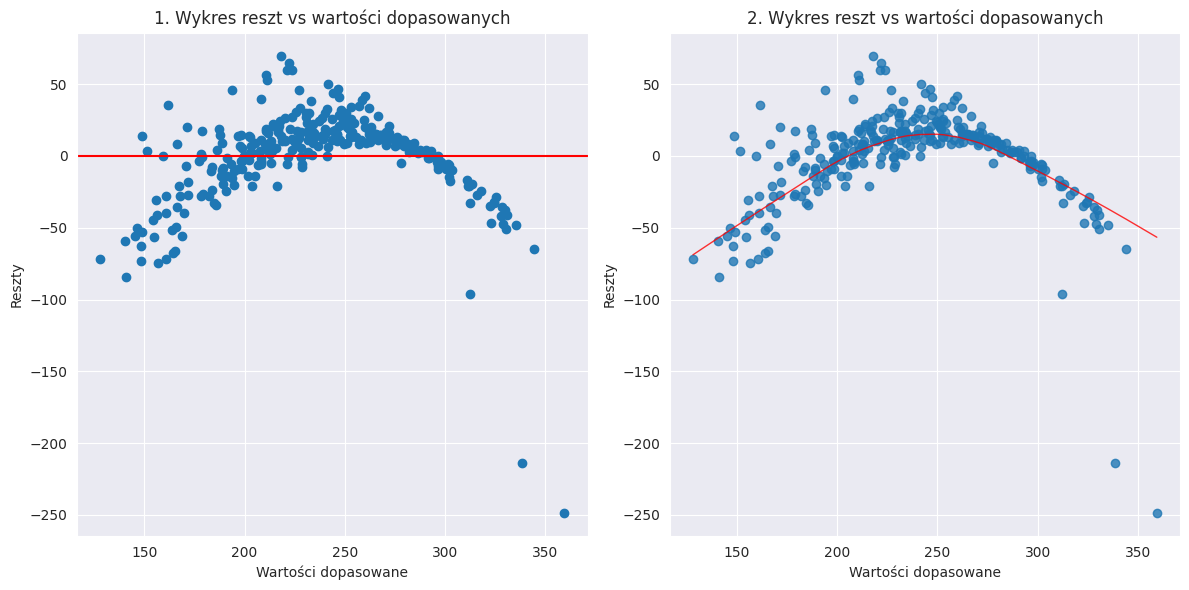

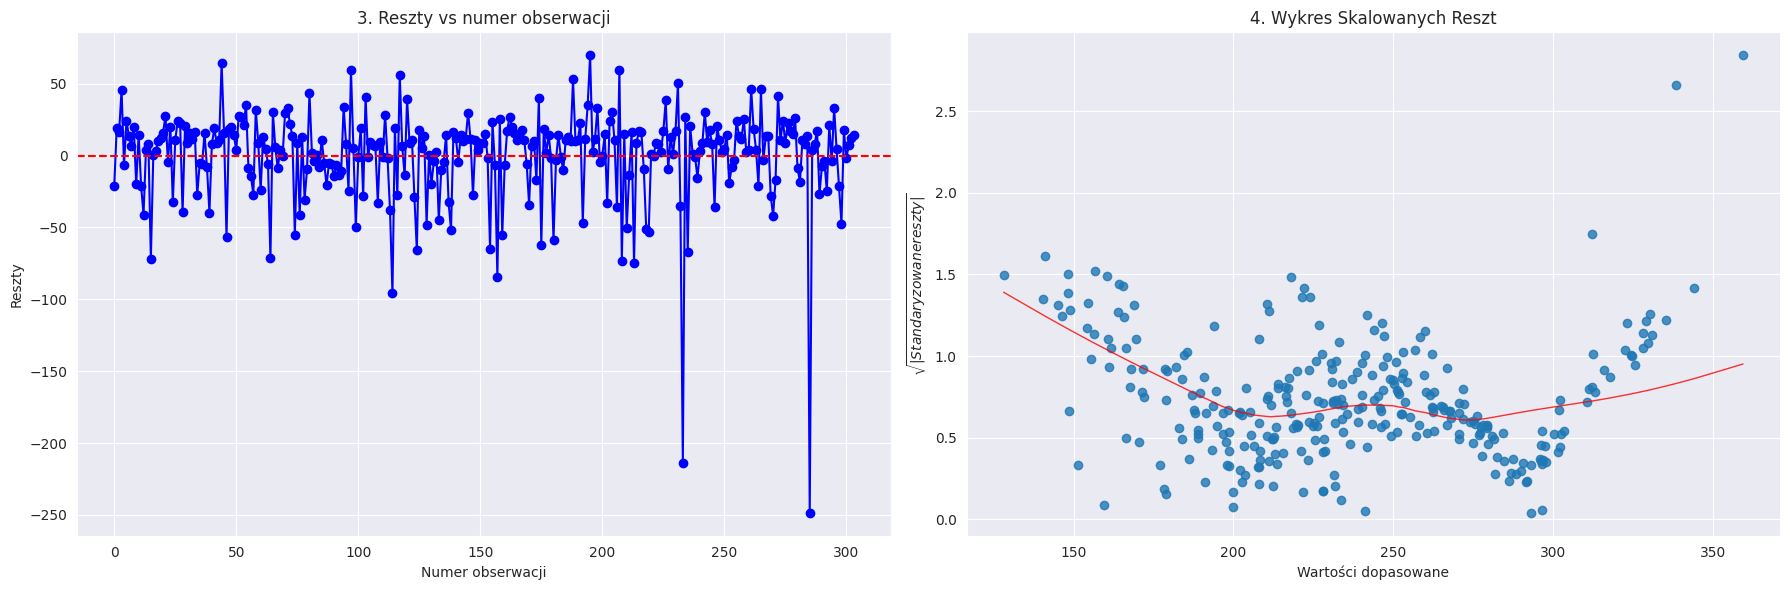

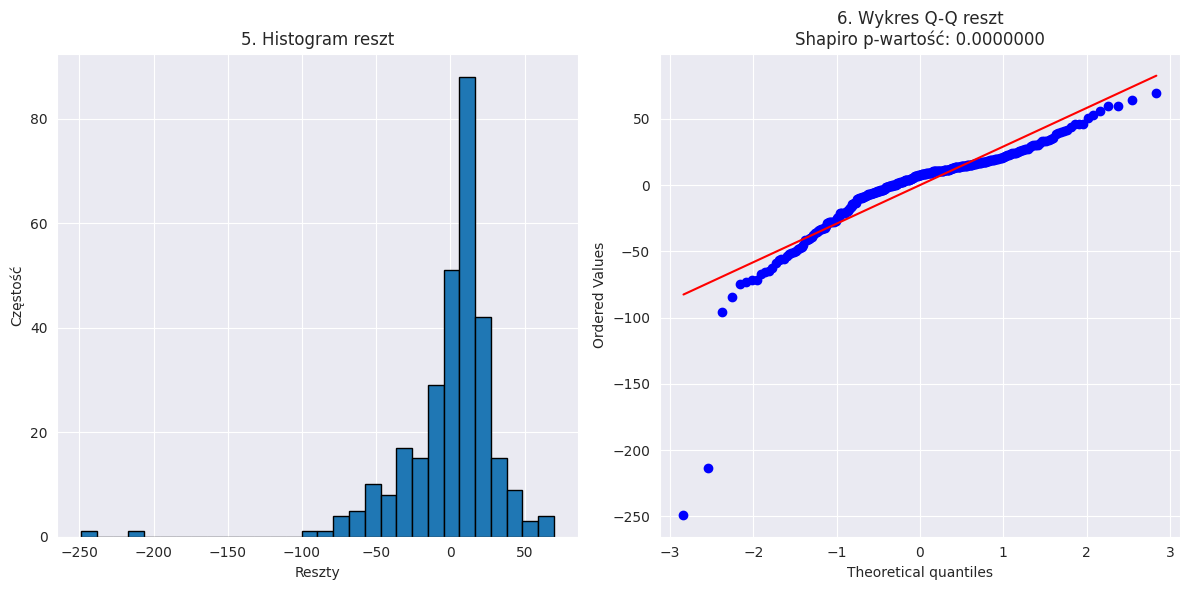

In [57]:
plot_diagnostics(results)

Na wykresie 1. oraz 2. widzimy trend oraz punkty nie są równomiernie rozłożone względem poziomej linii.
Ponadto, linia z 2. wykresu jest daleka od poziomej linii.

Z analizy wizualnej oraz testu RESET wnioskujemy, że założenie dotyczące liniowości formy funkcyjnej modelu nie jest spełnione.

***Wartość oczekiwana składnika losowego***

Do naszego modelu dodaliśmy stałą, wobec tego nie ma potrzeby sprawdzać założenia dotyczącego wartości oczekiwanej składnika losowego równej 0.

***Brak autokorelacji składnika losowego***

Na wykresie 3. nie obserwujemy trendu.

Wartości reszt oscylują wokół zera.

Wartość statystyki Durbin-Watson wynosi 2.101, co wskazuje na brak autokorelacji reszt, ponieważ jest ona zbliżona do 2.

Wnioskujemy, że założenie dotyczące braku autokorelacji składnika losowego jest spełnione.

***Homoskedastyczność***

Na wykresie 4. dostrzegamy trend, a nie chmurę punktów, więc wnioskujemy, że w naszym modelu występuje heteroskedastyczność.

Wartości nie są rozłożone symetrycznie na prostej poziomej linii. 

Z poczynionych powyżej obserwacji wynika, że w naszym modelu występuje heteroskedastyczność.

***Rozkład normalny składnika losowego***

Na wykresie 6. widzimy, że występuje odchylenie od rozkładu normalnego. Na wykresach 5 i 6 można zauważyć obserwacje odstające.

Ponadto, $p$-wartość z testu Shapiro-Wilka jest zdecydowanie niższa niż przyjęty przez nas poziom istotności.

Wartość statystyki Jarque-Bera (3842.37) jest daleko oddalona od zera, co sugeruje, że rozkład składnika losowego nie jest normalny.

Wnioskujemy, że rozkład składnika losowego nie pochodzi z rozkładu normalnego.

## 7.4)

Aby sprawdzić, czy w naszym modelu występuje problem niedokładniej współliniowości (multicollinearity) skorzystamy z czynniku inflacji wariancji (VIF):

In [58]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

#calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(len(X.columns))]

print(vif_data)

vif_sum = 0
for predictor, factor in vif_data.values:
    if predictor != 'const':
        vif_sum += factor

mean_vif = vif_sum / (len(vif_data.values) - 1)

print(f"\nŚredni VIF w naszym modelu: {mean_vif:.2f}")

            feature          VIF
0             const  2308.056223
1              waga     1.731495
2            wzrost     2.248774
3            dzieci     1.028401
4              wiek     1.203732
5            dochod     9.216374
6      oszczednosci    11.222733
7           jednoos     2.422016
8    plec_mezczyzna     2.625501
9      miejsce_male     1.499050
10  miejsce_srednie     1.478949

Średni VIF w naszym modelu: 3.47


VIF powyżej 10 sugeruje współliniowość dochodu oraz oszczędności. Zależność ta jest jednak wytłumaczalna w rzeczywistości, więc jej występowanie nie jest problemem.

Ponadto, z analizy eksploracyjnej, te predyktory związane są z wydatkami na żywność, więc nie powinniśmy wyrzucać ich z modelu.

W naszym modelu średni VIF jest równy 3.47, czyli jest mniejszy od 10, więc nie występuje w nim niedokładna współliniowość. 

## 7.5)

Baza zawiera błędy, ponieważ już na samym początku zidentyfikowaliśmy ujemne wydatki na żywność i pozbyliśmy się ich z naszego zbioru danych.

Tearz przeanalizujemy obserwacje korzystając z bazowego modelu.

Zbadamy obecności obserwacji odstających na podstawie wykresu wartości dźwigni i standaryzowanych reszt.

/tmp/ipykernel_25960/1732814629.py:1: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



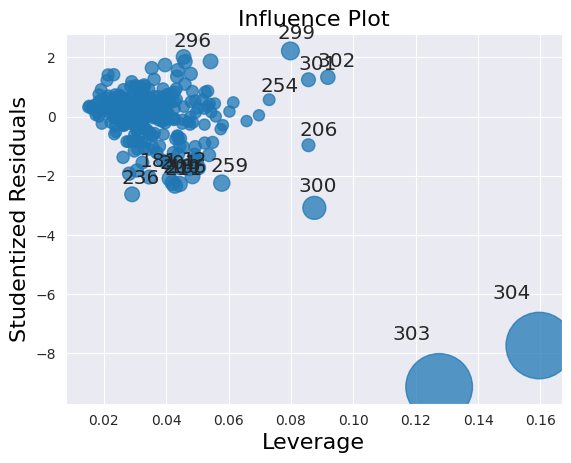

In [59]:
sm.graphics.influence_plot(results, criterion="cooks").show()

Podejrzenie wzbudzają obserwacje w prawym dolnym rogu, ponieważ mają jednocześnie wysokie wartości dźwigni i standaryzowanych reszt (patrzymy na wartości co do modułu większe niż 2).

Dlatego, zdecydowałem się usunąć obserwacje o id: 303 i 304.

In [60]:
bad_observations = [303, 304]

## 7.6)

Z eksploracyjnej analizy danych otrzymaliśmy liniową zależność pomiędzy wydatkami na żywność a interakcją dochódów i oszczędności.

Wobec tego użyjemy jej w modelu.

Kroki podjęte do otrzymania najlepszego modelu:
1. Z uwagi na nielinowość formy funkcyjnej wprowadzamy transformacje zmiennych (dochód$^2$, oszczędności$^2$) oraz interakcję pomiędzy zmiennymi (dochód $\cdot$ oszczędności).
2. Usuwamy predykoty, które nie są istotne statystycznie ($p$-wartość jest wyższa niż ustalony przez nas poziom istotności).
3. Usuwamy obserwacje odstające. 

In [61]:
def interact_income_savings(df_to_interact):
    df_to_interact['dochod_oszczednosci'] = df_to_interact['dochod'] * df_to_interact['oszczednosci']
    df_to_interact['dochod^2'] = df_to_interact['dochod'] * df_to_interact['dochod']
    df_to_interact['oszczednosci^2'] = df_to_interact['oszczednosci'] * df_to_interact['oszczednosci']
    
    return df_to_interact
   
def drop_observations(df_to_drop, observations_to_drop):
    return df_to_drop.drop(observations_to_drop)

In [62]:
def preprocess_data(input_df, perform_drop):
    input_df_copy = input_df.copy()
    input_df_copy = encode_categorical(input_df_copy)
    input_df_copy = interact_income_savings(input_df_copy)
    
    if perform_drop:
        input_df_copy = drop_observations(input_df_copy, bad_observations)

    _y = input_df_copy[target_variable]
    _X = input_df_copy.drop([target_variable], axis=1)
    _X = sm.add_constant(_X)
    
    # Wyrzucamy zmienne, które nie są statystycznie istotne.
    _X = _X.drop(['plec_mezczyzna', 'wzrost', 'miejsce_male', 'miejsce_srednie', 'jednoos'], axis=1)
                    
    return _X, _y

In [63]:
X, y = preprocess_data(df, True)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            wydatki_zyw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.038e+05
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        18:59:54   Log-Likelihood:                -446.44
No. Observations:                 302   AIC:                             910.9
Df Residuals:                     293   BIC:                             944.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.0128    

**Liniowość formy funkcyjnej**

Przeprowadzimy test RESET (Regression Specification Error Test) Ramseya, aby sprawdzić czy spełnione jest założenie o liniowości formy funkcyjnej modelu.

Stawiamy hipotezę zerową i alternatywną:

$$H_0:X\beta+\varepsilon$$
$$H_1:f(X\beta)+\varepsilon$$

gdzie f() nie jest liniową funkcją.

Ustalamy poziom istotności $\alpha = 0.01$ i obliczmy $p$-wartość.

In [64]:
ramsey_test(results)

<Wald test (chi2): statistic=1.0448253456517849, p-value=0.5930878933580535, df_denom=2>


Widzimy, że $p$-wartość jest zdecydowanie wyższa niż przyjęty przez nas poziom istotności. Zatem nie mamy podstaw do odrzucenia hipotezy zerowej - założenie dotyczące liniowości formy funkcyjnej modelu jest spełnione. 

Przechodzimy do analizy wizualnej.

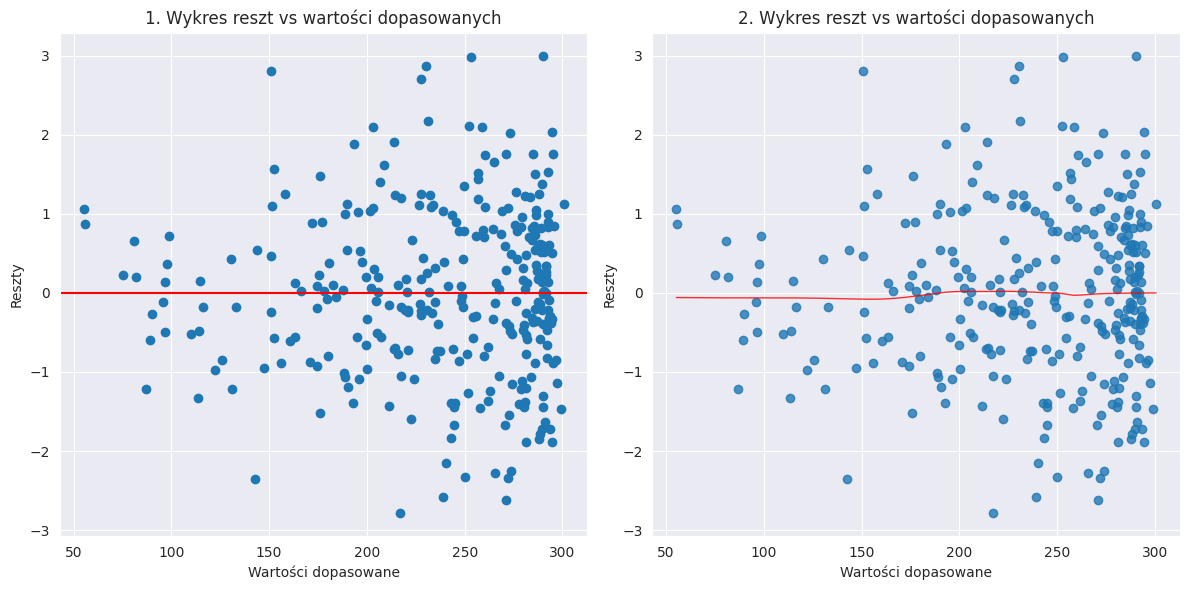

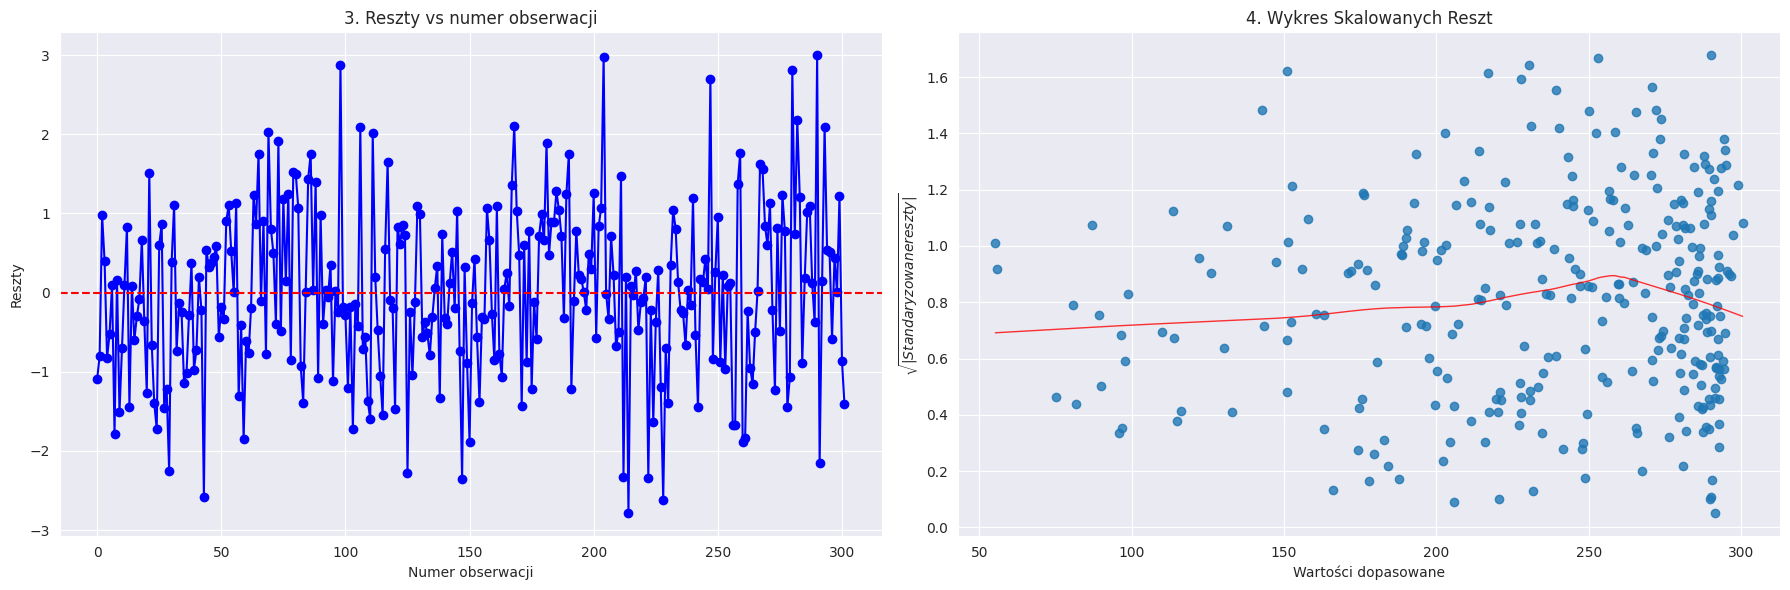

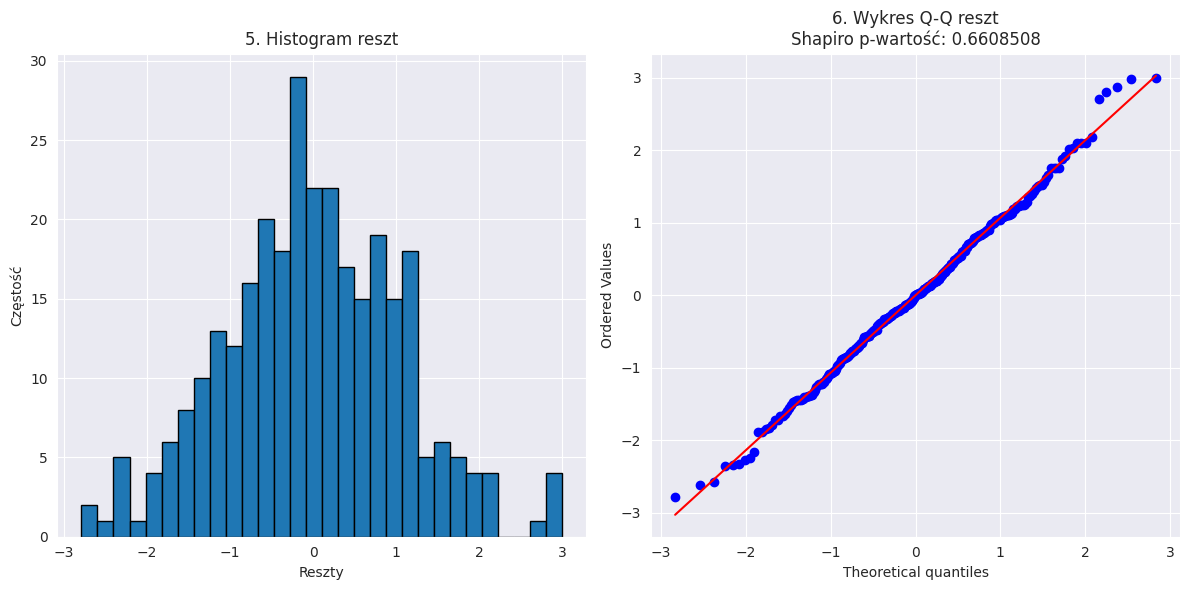

In [65]:
plot_diagnostics(results)

Na wykresie 1. oraz 2. obserwujemy chmurę punków, które są równomiernie rozłożone względem poziomej linii.
Ponadto, linia z 2. wykresu przypomina linię poziomą.

Z analizy wizualnej oraz testu RESET wnioskujemy, że założenie dotyczące liniowości formy funkcyjnej modelu jest spełnione.

***Wartość oczekiwana składnika losowego***

Do naszego modelu dodaliśmy stałą, wobec tego nie ma potrzeby sprawdzać założenia dotyczącego wartości oczekiwanej składnika losowego równej 0.

***Brak autokorelacji składnika losowego***

Na wykresie 3. nie obserwujemy trendu.

Wartości reszt oscylują wokół zera.

Wartość statystyki Durbin-Watson wynosi 1.836, co wskazuje na brak autokorelacji reszt, ponieważ jest ona zbliżona do 2.

Wnioskujemy, że założenie dotyczące braku autokorelacji składnika losowego jest spełnione.

***Homoskedastyczność***

Na wykresie 4. dostrzegamy chmurę punktów, więc wnioskujemy, że w naszym modelu występuje homoskedastyczność oraz brak autokorelacja składnika losowego.

Na wykresie 3. obserwujemy stałą wariancję - nie występują okresy wysokiej amplitudy przeplatające się z okresami niskiej.

Z poczynionych powyżej obserwacji wynika, że w naszym modelu występuje homoskedastyczność.

***Rozkład normalny składnika losowego***

Na wykresie 6. nie zauważamy odchylenia od rozkładu normalnego. Wykres przypomina rozkład normalny, a $p$-wartość jest wyższa niż przyjęty przez nas poziom istotności.

Wartość statystyki Jarque-Bera ( 0.307) jest bardzo bliska zeru, co sugeruje, że rozkład składnika losowego jest normalny.

Nie mamy podstaw do odrzucenia hipotezy zerowej - składnik losowy z dużym prawdopodobieństwem ma rozkład normalny. 

## 7.7)

Wybrałem zmienne: waga i liczba dzieci. Są one istotne, poniewaz $p$-wartość jest niższa niż przyjęty przez nas poziom istotności.

***Waga*** 
 
Współczynnik dla wagi wynosi 0.3624. Oznacza to, że przy niezmienionych wartościach pozostałych predyktorów, wzrost wagi o 1 kg jest związany ze wzrostem wydatków na żywność o 0.3624 bajtalarów.

***Dzieci***  

Współczynnik dla liczby dzieci wynosi 1.5122. Oznacza to, że przy niezmienionych wartościach pozostałych predyktorów, dodanie jednego dziecka do rodziny jest związane ze wzrostem wydatków na żywność o 1.5122 bajtalarów.


## 7.8)

Przewidujemy wydatki na żywność dla respondentów, a następnie wybieramy tych co najelżą do górnych 10% predykcji.

In [66]:
to_predict = df.copy()
X, _ = preprocess_data(to_predict, False)

to_predict['przewidywane_wydatki'] = results.predict(X)

top_10_percent = to_predict[to_predict['przewidywane_wydatki'] >= np.percentile(to_predict['przewidywane_wydatki'], 90)]
top_10_percent.describe()

waga      wzrost       plec     dzieci       wiek       dochod  \
count  31.000000   31.000000  31.000000  31.000000  31.000000    31.000000   
mean   81.281935  174.118065   1.645161   2.774194  52.645161  1531.661935   
std     2.208768    6.138403   0.486373   1.359158   5.907895   958.143241   
min    77.560000  159.970000   1.000000   0.000000  42.000000   753.680000   
25%    80.205000  171.145000   1.000000   2.000000  47.500000   883.270000   
50%    80.840000  174.660000   2.000000   3.000000  54.000000  1093.350000   
75%    82.360000  178.075000   2.000000   4.000000  56.500000  1798.800000   
max    86.060000  182.830000   2.000000   5.000000  65.000000  3893.040000   

       oszczednosci    jednoos   miejsce  wydatki_zyw  przewidywane_wydatki  
count     31.000000  31.000000  31.00000    31.000000             31.000000  
mean     761.912903   0.322581   2.16129   293.918065            293.919661  
std      964.411107   0.475191   0.77875     2.263714              2.140117  
min      -95.950000   0.000000   1.00000   291.050000            291.637959  
25%      122.870000   0.000000   2.00000   292.340000            292.576519  
50%      347.820000   0.000000   2.00000   293.440000            292.941767  
75%     1080.705000   1.000000   3.00000   294.855000            294.696684  
max     3086.410000   1.000000   3.00000   301.690000            300.563410

Pod poszczególnymi wykresami przedstawimy opisowe charakterystyki grupy osób, które należą do górnych 10% predycji wydatków na żywność.

In [67]:
plot_bar(top_10_percent)

- Jest prawie 2 razy więcej mężczyzn niż kobiet, natomiast w próbie mamy więcej kobiet,
- Ponad 80% osób ma co najmniej dwoje dzieci.
- Tylko jedna osoba ma więcej niż 60 lat, więc nie są to osoby starsze.
- Ponad dwa razy więcej osób mieszka w gospodarstwach wieloosobowych.
- Znacząca przewaga osób ze śrenich miejscowości zanikła, a za to mamy więcej osób z dużych miejscowości.

In [68]:
plot_histograms(top_10_percent, True)

- Waga prawie 50% osób mieści się pomiędzy 80, a 82 kilogrami.
- Przeważają osoby o wzroście większym niż 172 cm,
- Większość osób ma niskie dochody poniżej 600 bajtalarów miesięcznie,
- Większość osób ma niskie oszczędności, poniżej 1500 bajtalarów.

Podsumowując, większość osób, które należą do górnych 10% predykcji wydatków na żywność, to osoby:
- mężczyźni (ponad 50% osób),
- mające co najmniej dwoje dzieci na utrzymaniu,
- młodsze (poniżej 60 lat),
- prowadzące gospodarstwa wieloosobowe,
- o ponad przeciętnym wzroście (172 cm),
- mający niskie oszczędności i dochód.